This tutorial will walk you through how to use mixed precision for training and inference of your AI models utilizing the Intel AMX technology in the Intel® Xeon® processors. We will also demonstrate how to use CodeCarbon to measure the energy efficiency and compare the results between mixed precision (mixed_bfloat16) and single precision (float32). In this notebook, we particularly tested the TF-MELT repository with ANN, ResNET, and BNN models for this comparison between mixed precision (mixed_bfloat16) and single precision (float32) in both training and inference.

Note that, this code is for training on CPUs only since we are utilizing the Intel AMX technology in the Intel® Xeon® processors. For our tests, we used Intel® Xeon® Platinum 8470QL CPUs with 104 cores on Kestrel (NREL's HPC Cluster).

### Pre-requisite installs after tf-melt installation

In [1]:
!python -m pip install py-cpuinfo tensorflow-datasets matplotlib scikit-learn ipykernel codecarbon

To check if Intel AMX Technology is available on your CPU, run the following command. If it is available, you should see an output containing these flags: `amx_bf16`, `amx_tile` and `amx_int8`. 

In [1]:
!lscpu | grep amx

Flags:               fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush dts acpi mmx fxsr sse sse2 ss ht tm pbe syscall nx pdpe1gb rdtscp lm constant_tsc art arch_perfmon pebs bts rep_good nopl xtopology nonstop_tsc cpuid aperfmperf tsc_known_freq pni pclmulqdq dtes64 monitor ds_cpl smx est tm2 ssse3 sdbg fma cx16 xtpr pdcm pcid dca sse4_1 sse4_2 x2apic movbe popcnt tsc_deadline_timer aes xsave avx f16c rdrand lahf_lm abm 3dnowprefetch cpuid_fault epb cat_l3 cat_l2 cdp_l3 invpcid_single cdp_l2 ssbd mba ibrs ibpb stibp ibrs_enhanced fsgsbase tsc_adjust bmi1 avx2 smep bmi2 erms invpcid cqm rdt_a avx512f avx512dq rdseed adx smap avx512ifma clflushopt clwb intel_pt avx512cd sha_ni avx512bw avx512vl xsaveopt xsavec xgetbv1 xsaves cqm_llc cqm_occup_llc cqm_mbm_total cqm_mbm_local split_lock_detect avx_vnni avx512_bf16 wbnoinvd dtherm ida arat pln pts avx512vbmi umip pku ospke waitpkg avx512_vbmi2 gfni vaes vpclmulqdq avx512_vnni avx512_bitalg tme avx512_vpopcntdq

Next, if the CPU supports Intel AMX, to use the technology we need to set the following environment variable which will set the instruction set architecture (ISA) at the level that supports Intel AMX with both INT8 and bfloat16.

In [2]:
from cpuinfo import get_cpu_info
import os
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
tensor_cores = any("NVIDIA" in tf.config.experimental.get_device_details(gpu).get('device_name', '') for gpu in gpus)
metal_backend = any("Apple" in tf.config.experimental.get_device_details(gpu).get('device_name', '') for gpu in gpus)
amx_supported = any("amx" in flag for flag in get_cpu_info()['flags'])
if amx_supported:
    os.environ["ONEDNN_MAX_CPU_ISA"] = "AVX512_CORE_AMX"
    print("Intel CPU detected. AMX is enabled")
elif tensor_cores:
    print("Nvidia GPU detected. AMX is not supported. Using Tensor Cores instead.")
elif metal_backend:
    print("Apple GPU detected. AMX is not supported. Using Metal backend instead.")
else:
    print("Mixed precision is not supported on this hardware")

2024-07-23 12:15:38.311139: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-23 12:15:40.294645: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-23 12:15:40.295596: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-23 12:15:40.452812: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-23 12:15:41.184646: I tensorflow/core/platform/cpu_feature_guar

Intel CPU detected. AMX is enabled


In the training process, we will be enabling mixed precision training with `bfloat16` by using the `tf.config` API and setting the option `'auto_mixed_precision_onednn_bfloat16':True`.

### Intel ResNET-50 Example
First, we demonstrate the speedup performance from an example from Intel using the ResNET-50 model for classification on the CIFAR-10 dataset.  We also measured Energy Consumtion using the tool `CodeCarbon`. This example will be a baseline to which we can compare our results with.

In [3]:
import os
import time
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from codecarbon import EmissionsTracker

# Hyperparameters and constants
LR = 0.001
MOMENTUM = 0.9
BATCH_SIZE = 128
EPOCHS = 1
DATA = 'datasets/cifar10/'

# Load dataset
def preprocess(data):
    image = tf.image.resize(data['image'], (224, 224))
    image = tf.cast(image, tf.float32) / 255.0
    return image, data['label']
    
train_dataset, info = tfds.load('cifar10', split='train', with_info=True, as_supervised=False, data_dir=DATA)
train_dataset = train_dataset.map(preprocess).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)

def trainModel(train_dataset, modelName="myModel", dataType="fp32"):
    # Set mixed precision policy
    if dataType == "bf16":
        if amx_supported:
            print("Enabling Mixed Precision (mixed_bfloat16) with AMX")
            tf.config.optimizer.set_experimental_options({'auto_mixed_precision_onednn_bfloat16':True})
        elif tensor_cores:
            print("Enabling Mixed Precision (mixed_bfloat16) with Tensor Cores")
            tf.config.optimizer.set_experimental_options({'auto_mixed_precision_onednn_bfloat16':False})
            tf.keras.mixed_precision.set_global_policy('mixed_bfloat16')
        elif metal_backend:
            print("Enabling Mixed Precision (mixed_bfloat16) with Metal backend")
            tf.config.optimizer.set_experimental_options({'auto_mixed_precision_onednn_bfloat16':False})
            tf.keras.mixed_precision.set_global_policy('mixed_bfloat16')
    else:
        tf.config.optimizer.set_experimental_options({'auto_mixed_precision_onednn_bfloat16':False})
        tf.keras.mixed_precision.set_global_policy('float32')
    
    # Initialize the model
    model = tf.keras.applications.ResNet50(weights=None, input_shape=(224, 224, 3), classes=10)
    model.compile(
        optimizer=tf.keras.optimizers.SGD(learning_rate=LR, momentum=MOMENTUM),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    # Train the model
    tracker = EmissionsTracker()
    tracker.start()
    start_time = time.time()
    history = model.fit(train_dataset, epochs=EPOCHS)
    end_time = time.time()
    emissions: float = tracker.stop()
    total_energy = tracker.final_emissions_data.energy_consumed
    training_time = end_time - start_time
    print(f"Training took {training_time:.3f} seconds")
        
    return history, training_time, emissions, total_energy

In [ ]:
# Train models and acquire training times
print("Training model with FP32")
fp32_history, fp32_training_time, fp32_emissions, fp32_total_energy = trainModel(train_dataset, modelName="fp32", dataType="fp32")
print("Training model with BF16")
bf16_history, bf16_training_time, bf16_emissions, bf16_total_energy = trainModel(train_dataset, modelName="bf16", dataType="bf16")

Training model with FP32


[codecarbon INFO @ 11:25:28] [setup] RAM Tracking...
[codecarbon INFO @ 11:25:28] [setup] GPU Tracking...
[codecarbon INFO @ 11:25:28] No GPU found.
[codecarbon INFO @ 11:25:28] [setup] CPU Tracking...
[codecarbon INFO @ 11:25:28] Tracking Intel CPU via RAPL interface
[codecarbon INFO @ 11:25:28] >>> Tracker's metadata:
[codecarbon INFO @ 11:25:28]   Platform system: Linux-4.18.0-477.10.1.el8_8.x86_64-x86_64-with-glibc2.28
[codecarbon INFO @ 11:25:28]   Python version: 3.11.9
[codecarbon INFO @ 11:25:28]   CodeCarbon version: 2.5.0
[codecarbon INFO @ 11:25:28]   Available RAM : 246.064 GB
[codecarbon INFO @ 11:25:28]   CPU count: 104
[codecarbon INFO @ 11:25:28]   CPU model: Intel(R) Xeon(R) Platinum 8470QL
[codecarbon INFO @ 11:25:28]   GPU count: None
[codecarbon INFO @ 11:25:28]   GPU model: None
[codecarbon INFO @ 11:25:31] Saving emissions data to file /home/ttahmid/applications_test/AI/supervised/regression/emissions.csv
[codecarbon INFO @ 11:25:46] Energy consumed for RAM : 0.00

In [6]:
# Training time results with loss
if amx_supported:
    print("ResNet-50 Training Summary on CPU")
elif tensor_cores:
    print("ResNet-50 Training Summary on GPU")
print(f"FP32 training time: {fp32_training_time:.3f} seconds with loss: {fp32_history.history['loss'][-1]}")
print(f"BF16 training time: {bf16_training_time:.3f} seconds with loss: {bf16_history.history['loss'][-1]}")
print(f"FP32 total consumed energy: {fp32_total_energy:.5f} J with emissions: {fp32_emissions:.5f} kgCO2")
print(f"BF16 total consumed energy: {bf16_total_energy:.5f} J with emissions: {bf16_emissions:.5f} kgCO2")
print(f"FP32 EDP (Energy Delay Product): {fp32_training_time * fp32_total_energy:.3f} J*s")
print(f"BF16 EDP (Energy Delay Product): {bf16_training_time * bf16_total_energy:.3f} J*s")

# Calculate speedup and accuracy loss when using BF16
speedup_from_fp32 = fp32_training_time / bf16_training_time
accuracy_loss = (fp32_history.history['loss'][-1] - bf16_history.history['loss'][-1]) / fp32_history.history['loss'][-1]
print(f"BF16 is {speedup_from_fp32:.2f}X faster than FP32 with {accuracy_loss:.2f}% accuracy loss")
# Calcualte the Emissions and EDP reduction percentage
emissions_reduction = ((fp32_emissions - bf16_emissions) / fp32_emissions) * 100
edp_reduction = (((fp32_training_time * fp32_total_energy) - (bf16_training_time * bf16_total_energy)) / (fp32_training_time * fp32_total_energy)) * 100
print(f"BF16 reduces emissions by {emissions_reduction:.2f}% and EDP by {edp_reduction:.2f}% than FP32")

ResNet-50 Training Summary on CPU
FP32 training time: 439.161 seconds with loss: 1.912419080734253
BF16 training time: 238.805 seconds with loss: 1.9085620641708374
FP32 total consumed energy: 0.09217 J with emissions: 0.03393 kgCO2
BF16 total consumed energy: 0.05090 J with emissions: 0.01874 kgCO2
FP32 EDP (Energy Delay Product): 40.478 J*s
BF16 EDP (Energy Delay Product): 12.154 J*s
BF16 is 1.84X faster than FP32
BF16 reduces emissions by 44.78%
BF16 reduces EDP by 69.97%


We also import results from our runs with 10 EPOCHS on Kestrel CPU Compute Nodes

In [3]:
from collections import deque
import tarfile
import os

dir_name = 'mixed_precision_outputs'

if not os.path.exists(dir_name):
    with tarfile.open(dir_name + ".tar") as tar:
        tar.extractall()

with open(dir_name + '/logs/ResNet-50 Training Summary on CPU.out', 'r') as file:
    last_lines = deque(file, maxlen=24)
    print(''.join(list(last_lines)[:-14]))

ResNet-50 Training Summary on CPU
FP32 training time: 437.767 seconds with loss: 1.918412208557129
BF16 training time: 242.348 seconds with loss: 1.8974403142929077
FP32 emissions: 0.034 kgCO2
BF16 emissions: 0.019 kgCO2
FP32 EDP: 14.823 kgCO2*s
BF16 EDP: 4.592 kgCO2*s
BF16 is 1.81X faster than FP32
BF16 reduces emissions by 44.04%
BF16 reduces EDP by 69.02%



### TF-MELT Examples
For our testing purposes, we will be using a similar synthetic data for a regression task used in the other tutorials for all training models (ANN, ResNET, BNN). The dataset is defined as follows:

In [3]:
# First, the imports
import os
import time
from codecarbon import EmissionsTracker
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.datasets import make_regression
from tfmelt.utils.preprocessing import get_normalizers
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
from tfmelt.models import ArtificialNeuralNetwork, ResidualNeuralNetwork, BayesianNeuralNetwork
from tfmelt.utils.visualization import plot_history
from tfmelt.utils.evaluation import make_predictions
from tfmelt.utils.visualization import plot_predictions
from tfmelt.utils.evaluation import ensemble_predictions
from tfmelt.utils.visualization import plot_predictions_with_uncertainty


In [4]:
# Hyperparameters and constants
LR = 0.001
BATCH_SIZE = 4000

n_samples = 50000
n_features = 4000
n_targets = 10
noise = 1.0
n_epochs = 10

# Set seeds for reproducibility
tf.keras.utils.set_random_seed(42)  # sets seeds for base-python, numpy and tf
tf.config.experimental.enable_op_determinism()

# Create synthetic regression data
x, y = make_regression(
        n_samples=n_samples, 
        n_features=n_features, 
        n_informative=n_features // 2, 
        n_targets=n_targets, 
        noise=noise, 
        random_state=42,
)
print(f"Shape of x: {x.shape}, Shape of y: {y.shape}")

# Get the normalizers using the tfmelt library
x_normalizer, y_normalizer = get_normalizers(norm_type="standard", n_normalizers=2)

# Fit the normalizers
x_normalizer.fit(x)
y_normalizer.fit(y)

# Normalize the data
x_norm = x_normalizer.transform(x)
y_norm = y_normalizer.transform(y)

# Create the train and test datasets
x_train, x_test, y_train, y_test = train_test_split(x_norm, y_norm, test_size=0.2, random_state=42)
# Create the validation dataset from the test dataset
x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size=0.5, random_state=42)

# Precompute the un-normalized data for later use
y_train_real = y_normalizer.inverse_transform(y_train)
y_test_real = y_normalizer.inverse_transform(y_test)
y_val_real = y_normalizer.inverse_transform(y_val)

Shape of x: (50000, 4000), Shape of y: (50000, 10)


Next, let us define our training models (ANN, ResNET, and BNN)

In [5]:
ann_model = ArtificialNeuralNetwork(
        num_outputs=n_targets,
        width=4000,
        depth=50,
        act_fun="relu",
        l1_reg=0,
        l2_reg=0,
        input_dropout=0.1,
        dropout=0.1,
        batch_norm=True,
        output_activation="linear",
)

resnet_model = ResidualNeuralNetwork(
        num_outputs=n_targets,
        width=4000,
        depth=50,
        layers_per_block=2,
        act_fun="relu",
        l1_reg=0,
        l2_reg=0,
        input_dropout=0.1,
        dropout=0.1,
        batch_norm=True,
        pre_activation=True,
        post_add_activation=False,
        output_activation="linear",
)

bnn_model = BayesianNeuralNetwork(
        num_outputs=n_targets,
        act_fun="relu",
        l1_reg=0,
        l2_reg=0,
        input_dropout=0.1,
        dropout=0.5,
        batch_norm=True,
        output_activation="linear",
        num_points=x_train.shape[0],
        do_bayesian_output=True,
        do_aleatoric=False,
        node_list=[4000, 4000, 4000, 4000, 4000, 1024],
        bayesian_mask=[True, True, True, True, True, True],
)

In the trainModel function (similar to Intel example) below, we set the `'auto_mixed_precision_onednn_bfloat16':True` option if the data type is `bfloat16` and train the models with both mixed precision (`bfloat16`) and single precision (`float32`) to measure the speedup. Since training 100 epochs for large networks takes a very long time we also import results for training scripts run in Kestrel to show the Speedup and Energy Efficieny.

In [7]:
def trainModel(x_train, y_train, x_val, y_val, model, dataType="fp32"):
    # Set mixed precision policy
    if dataType == "bf16":
        if amx_supported:
            print("Enabling Mixed Precision (mixed_bfloat16) with AMX")
            tf.config.optimizer.set_experimental_options({'auto_mixed_precision_onednn_bfloat16':True})
        elif tensor_cores:
            print("Enabling Mixed Precision (mixed_bfloat16) with Tensor Cores")
            tf.config.optimizer.set_experimental_options({'auto_mixed_precision_onednn_bfloat16':False})
            tf.keras.mixed_precision.set_global_policy('mixed_bfloat16')
        elif metal_backend:
            print("Enabling Mixed Precision (mixed_bfloat16) with Metal backend")
            tf.config.optimizer.set_experimental_options({'auto_mixed_precision_onednn_bfloat16':False})
            tf.keras.mixed_precision.set_global_policy('mixed_bfloat16')
    else:
        tf.config.optimizer.set_experimental_options({'auto_mixed_precision_onednn_bfloat16':False})
        tf.keras.mixed_precision.set_global_policy('float32')
    
    # Build model and print summary
    model.build(input_shape=(None, n_features))

    # Set the optimizer with loss scaling
    base_optimizer = Adam(learning_rate=LR)
    if dataType == "bf16":
        optimizer = tf.keras.mixed_precision.LossScaleOptimizer(base_optimizer)
    else:
        optimizer = base_optimizer

    model.compile(
        optimizer=optimizer,
        loss='mse',
    )
    model.summary()

    # Train the model
    tracker = EmissionsTracker()
    tracker.start()
    start_time = time.time()
    history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=n_epochs, batch_size=BATCH_SIZE, shuffle=True)
    end_time = time.time()
    emissions: float = tracker.stop()
    total_energy = tracker.final_emissions_data.energy_consumed
    training_time = end_time - start_time
    print(f"Training took {training_time:.3f} seconds")
        
    return history, training_time, emissions, total_energy

### ANN Training

In [8]:
# Train ANN model and acquire training times
print("Training ANN model with FP32")
ann_fp32_history, ann_fp32_training_time, ann_fp32_emissions, ann_fp32_total_energy = trainModel(x_train, y_train, x_val, y_val, ann_model, dataType="fp32")

Training ANN model with FP32
Model: "artificial_neural_network"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_dropout (Dropout)     multiple                  0         
                                                                 
 output (DefaultOutput)      multiple                  40010     
                                                                 
 dense_block (DenseBlock)    multiple                  801000000 
                                                                 
Total params: 801040010 (2.98 GB)
Trainable params: 800640010 (2.98 GB)
Non-trainable params: 400000 (1.53 MB)
_________________________________________________________________
Model: "output"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 output (Dense)              multiple                  40010     
                 

                                                                 
 dropout_0 (Dropout)         multiple                  0         
                                                                 
 dropout_1 (Dropout)         multiple                  0         
                                                                 
 dropout_2 (Dropout)         multiple                  0         
                                                                 
 dropout_3 (Dropout)         multiple                  0         
                                                                 
 dropout_4 (Dropout)         multiple                  0         
                                                                 
 dropout_5 (Dropout)         multiple                  0         
                                                                 
 dropout_6 (Dropout)         multiple                  0         
                                                                 
 dropout_7

 batch_norm_8 (BatchNormali  multiple                  16000     
 zation)                                                         
                                                                 
 batch_norm_9 (BatchNormali  multiple                  16000     
 zation)                                                         
                                                                 
 batch_norm_10 (BatchNormal  multiple                  16000     
 ization)                                                        
                                                                 
 batch_norm_11 (BatchNormal  multiple                  16000     
 ization)                                                        
                                                                 
 batch_norm_12 (BatchNormal  multiple                  16000     
 ization)                                                        
                                                                 
 batch_nor

                                                                 
 dense_0 (Dense)             multiple                  16004000  
                                                                 
 dense_1 (Dense)             multiple                  16004000  
                                                                 
 dense_2 (Dense)             multiple                  16004000  
                                                                 
 dense_3 (Dense)             multiple                  16004000  
                                                                 
 dense_4 (Dense)             multiple                  16004000  
                                                                 
 dense_5 (Dense)             multiple                  16004000  
                                                                 
 dense_6 (Dense)             multiple                  16004000  
                                                                 
 dense_7 (

[codecarbon INFO @ 11:28:37] [setup] RAM Tracking...
[codecarbon INFO @ 11:28:37] [setup] GPU Tracking...
[codecarbon INFO @ 11:28:37] No GPU found.
[codecarbon INFO @ 11:28:37] [setup] CPU Tracking...
[codecarbon INFO @ 11:28:37] Tracking Intel CPU via RAPL interface
[codecarbon INFO @ 11:28:38] >>> Tracker's metadata:
[codecarbon INFO @ 11:28:38]   Platform system: Linux-4.18.0-477.10.1.el8_8.x86_64-x86_64-with-glibc2.28
[codecarbon INFO @ 11:28:38]   Python version: 3.11.9
[codecarbon INFO @ 11:28:38]   CodeCarbon version: 2.5.0
[codecarbon INFO @ 11:28:38]   Available RAM : 246.064 GB
[codecarbon INFO @ 11:28:38]   CPU count: 104
[codecarbon INFO @ 11:28:38]   CPU model: Intel(R) Xeon(R) Platinum 8470QL
[codecarbon INFO @ 11:28:38]   GPU count: None
[codecarbon INFO @ 11:28:38]   GPU model: None
[codecarbon INFO @ 11:28:41] Saving emissions data to file /home/ttahmid/applications_test/AI/supervised/regression/emissions.csv


Epoch 1/10


[codecarbon INFO @ 11:28:56] Energy consumed for RAM : 0.000385 kWh. RAM Power : 92.27400000000002 W
[codecarbon INFO @ 11:28:56] Energy consumed for all CPUs : 0.002003 kWh. Total CPU Power : 480.42467019281173 W
[codecarbon INFO @ 11:28:56] 0.002387 kWh of electricity used since the beginning.


 5/10 [==============>...............] - ETA: 17s - loss: 26.1222

[codecarbon INFO @ 11:29:11] Energy consumed for RAM : 0.000769 kWh. RAM Power : 92.27400000000002 W
[codecarbon INFO @ 11:29:11] Energy consumed for all CPUs : 0.004901 kWh. Total CPU Power : 695.3484961911021 W
[codecarbon INFO @ 11:29:11] 0.005670 kWh of electricity used since the beginning.


 9/10 [==========================>...] - ETA: 3s - loss: 15.1579

[codecarbon INFO @ 11:29:26] Energy consumed for RAM : 0.001154 kWh. RAM Power : 92.27400000000002 W
[codecarbon INFO @ 11:29:26] Energy consumed for all CPUs : 0.007804 kWh. Total CPU Power : 696.3905944491928 W
[codecarbon INFO @ 11:29:26] 0.008957 kWh of electricity used since the beginning.


10/10 [==============================] - 49s 4s/step - loss: 13.7772 - val_loss: 17102216175288320000.0000
Epoch 2/10
 2/10 [=====>........................] - ETA: 29s - loss: 1.2310

[codecarbon INFO @ 11:29:41] Energy consumed for RAM : 0.001538 kWh. RAM Power : 92.27400000000002 W
[codecarbon INFO @ 11:29:41] Energy consumed for all CPUs : 0.010652 kWh. Total CPU Power : 683.3029061694164 W
[codecarbon INFO @ 11:29:41] 0.012191 kWh of electricity used since the beginning.


 7/10 [====================>.........] - ETA: 10s - loss: 1.1596

[codecarbon INFO @ 11:29:56] Energy consumed for RAM : 0.001923 kWh. RAM Power : 92.27400000000002 W
[codecarbon INFO @ 11:29:56] Energy consumed for all CPUs : 0.013553 kWh. Total CPU Power : 696.329451266077 W
[codecarbon INFO @ 11:29:56] 0.015476 kWh of electricity used since the beginning.


10/10 [==============================] - 37s 4s/step - loss: 1.1542 - val_loss: 7614297792499941376.0000
Epoch 3/10


[codecarbon INFO @ 11:30:11] Energy consumed for RAM : 0.002307 kWh. RAM Power : 92.27400000000002 W
[codecarbon INFO @ 11:30:11] Energy consumed for all CPUs : 0.016456 kWh. Total CPU Power : 696.1471333117474 W
[codecarbon INFO @ 11:30:11] 0.018763 kWh of electricity used since the beginning.


 5/10 [==============>...............] - ETA: 18s - loss: 1.1061

[codecarbon INFO @ 11:30:26] Energy consumed for RAM : 0.002692 kWh. RAM Power : 92.27400000000002 W
[codecarbon INFO @ 11:30:26] Energy consumed for all CPUs : 0.019363 kWh. Total CPU Power : 697.711613067416 W
[codecarbon INFO @ 11:30:26] 0.022055 kWh of electricity used since the beginning.


 9/10 [==========================>...] - ETA: 3s - loss: 1.0978

[codecarbon INFO @ 11:30:41] Energy consumed for RAM : 0.003076 kWh. RAM Power : 92.27400000000002 W
[codecarbon INFO @ 11:30:41] Energy consumed for all CPUs : 0.022259 kWh. Total CPU Power : 695.2851973464813 W
[codecarbon INFO @ 11:30:41] 0.025336 kWh of electricity used since the beginning.
[codecarbon ERROR @ 11:30:41] Region:  not found for Country with ISO CODE : USA
Traceback (most recent call last):
  File "/home/ttahmid/.conda-envs/tf-melt/lib/python3.11/site-packages/codecarbon/core/emissions.py", line 142, in get_private_infra_emissions
    return self.get_region_emissions(energy, geo)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/ttahmid/.conda-envs/tf-melt/lib/python3.11/site-packages/codecarbon/core/emissions.py", line 168, in get_region_emissions
    raise ValueError(
ValueError: Region:  not found for Country with ISO CODE : USA
[codecarbon WARNING @ 11:30:41] Regional emissions retrieval failed. Falling back on country emissions.
[codecarbon INFO @ 1

10/10 [==============================] - 38s 4s/step - loss: 1.0928 - val_loss: 141231879356416.0000
Epoch 4/10
 2/10 [=====>........................] - ETA: 29s - loss: 1.0659

[codecarbon INFO @ 11:30:56] Energy consumed for RAM : 0.003461 kWh. RAM Power : 92.27400000000002 W
[codecarbon INFO @ 11:30:56] Energy consumed for all CPUs : 0.025163 kWh. Total CPU Power : 696.6962477010215 W
[codecarbon INFO @ 11:30:56] 0.028624 kWh of electricity used since the beginning.


 7/10 [====================>.........] - ETA: 10s - loss: 1.0881

[codecarbon INFO @ 11:31:11] Energy consumed for RAM : 0.003845 kWh. RAM Power : 92.27400000000002 W
[codecarbon INFO @ 11:31:11] Energy consumed for all CPUs : 0.028071 kWh. Total CPU Power : 697.9614151008473 W
[codecarbon INFO @ 11:31:11] 0.031916 kWh of electricity used since the beginning.


10/10 [==============================] - 38s 4s/step - loss: 1.0750 - val_loss: 7762622976.0000
Epoch 5/10


[codecarbon INFO @ 11:31:26] Energy consumed for RAM : 0.004230 kWh. RAM Power : 92.27400000000002 W
[codecarbon INFO @ 11:31:26] Energy consumed for all CPUs : 0.030970 kWh. Total CPU Power : 695.9448309644207 W
[codecarbon INFO @ 11:31:26] 0.035200 kWh of electricity used since the beginning.


 4/10 [===========>..................] - ETA: 22s - loss: 1.0794

[codecarbon INFO @ 11:31:41] Energy consumed for RAM : 0.004614 kWh. RAM Power : 92.27400000000002 W
[codecarbon INFO @ 11:31:41] Energy consumed for all CPUs : 0.033875 kWh. Total CPU Power : 697.2379102941477 W
[codecarbon INFO @ 11:31:41] 0.038489 kWh of electricity used since the beginning.


 8/10 [=======================>......] - ETA: 7s - loss: 1.0883 

[codecarbon INFO @ 11:31:56] Energy consumed for RAM : 0.004998 kWh. RAM Power : 92.27400000000002 W
[codecarbon INFO @ 11:31:56] Energy consumed for all CPUs : 0.036778 kWh. Total CPU Power : 696.7564686897927 W
[codecarbon INFO @ 11:31:56] 0.041777 kWh of electricity used since the beginning.


10/10 [==============================] - 38s 4s/step - loss: 1.0879 - val_loss: 11289441.0000
Epoch 6/10
 2/10 [=====>........................] - ETA: 30s - loss: 1.0803

[codecarbon INFO @ 11:32:11] Energy consumed for RAM : 0.005383 kWh. RAM Power : 92.27400000000002 W
[codecarbon INFO @ 11:32:11] Energy consumed for all CPUs : 0.039666 kWh. Total CPU Power : 692.7702838489001 W
[codecarbon INFO @ 11:32:11] 0.045049 kWh of electricity used since the beginning.


 6/10 [=================>............] - ETA: 15s - loss: 1.0852

[codecarbon INFO @ 11:32:26] Energy consumed for RAM : 0.005768 kWh. RAM Power : 92.27400000000002 W
[codecarbon INFO @ 11:32:26] Energy consumed for all CPUs : 0.042561 kWh. Total CPU Power : 694.7202093774029 W
[codecarbon INFO @ 11:32:26] 0.048329 kWh of electricity used since the beginning.


10/10 [==============================] - 39s 4s/step - loss: 1.0793 - val_loss: 36492.5039
Epoch 7/10


[codecarbon INFO @ 11:32:41] Energy consumed for RAM : 0.006152 kWh. RAM Power : 92.27400000000002 W
[codecarbon INFO @ 11:32:41] Energy consumed for all CPUs : 0.045461 kWh. Total CPU Power : 695.5488621545566 W
[codecarbon INFO @ 11:32:41] 0.051613 kWh of electricity used since the beginning.
[codecarbon ERROR @ 11:32:41] Region:  not found for Country with ISO CODE : USA
Traceback (most recent call last):
  File "/home/ttahmid/.conda-envs/tf-melt/lib/python3.11/site-packages/codecarbon/core/emissions.py", line 142, in get_private_infra_emissions
    return self.get_region_emissions(energy, geo)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/ttahmid/.conda-envs/tf-melt/lib/python3.11/site-packages/codecarbon/core/emissions.py", line 168, in get_region_emissions
    raise ValueError(
ValueError: Region:  not found for Country with ISO CODE : USA
[codecarbon WARNING @ 11:32:41] Regional emissions retrieval failed. Falling back on country emissions.
[codecarbon INFO @ 1

 4/10 [===========>..................] - ETA: 23s - loss: 1.0866

[codecarbon INFO @ 11:32:56] Energy consumed for RAM : 0.006537 kWh. RAM Power : 92.27400000000002 W
[codecarbon INFO @ 11:32:56] Energy consumed for all CPUs : 0.048365 kWh. Total CPU Power : 697.176914785359 W
[codecarbon INFO @ 11:32:56] 0.054902 kWh of electricity used since the beginning.


 7/10 [====================>.........] - ETA: 11s - loss: 1.0777

[codecarbon INFO @ 11:33:11] Energy consumed for RAM : 0.006921 kWh. RAM Power : 92.27400000000002 W
[codecarbon INFO @ 11:33:11] Energy consumed for all CPUs : 0.051266 kWh. Total CPU Power : 695.7517695627998 W
[codecarbon INFO @ 11:33:11] 0.058187 kWh of electricity used since the beginning.


10/10 [==============================] - 40s 4s/step - loss: 1.0749 - val_loss: 607.2000
Epoch 8/10
 1/10 [==>...........................] - ETA: 33s - loss: 1.0542

[codecarbon INFO @ 11:33:26] Energy consumed for RAM : 0.007306 kWh. RAM Power : 92.27400000000002 W
[codecarbon INFO @ 11:33:26] Energy consumed for all CPUs : 0.054146 kWh. Total CPU Power : 691.137910578295 W
[codecarbon INFO @ 11:33:26] 0.061452 kWh of electricity used since the beginning.


 5/10 [==============>...............] - ETA: 19s - loss: 1.0764

[codecarbon INFO @ 11:33:41] Energy consumed for RAM : 0.007690 kWh. RAM Power : 92.27400000000002 W
[codecarbon INFO @ 11:33:41] Energy consumed for all CPUs : 0.057049 kWh. Total CPU Power : 696.7973103977225 W
[codecarbon INFO @ 11:33:41] 0.064739 kWh of electricity used since the beginning.


 9/10 [==========================>...] - ETA: 3s - loss: 1.0692

[codecarbon INFO @ 11:33:56] Energy consumed for RAM : 0.008075 kWh. RAM Power : 92.27400000000002 W
[codecarbon INFO @ 11:33:56] Energy consumed for all CPUs : 0.059954 kWh. Total CPU Power : 697.1528140417579 W
[codecarbon INFO @ 11:33:56] 0.068028 kWh of electricity used since the beginning.


10/10 [==============================] - 41s 4s/step - loss: 1.0650 - val_loss: 12.9912
Epoch 9/10
 2/10 [=====>........................] - ETA: 33s - loss: 1.0730

[codecarbon INFO @ 11:34:11] Energy consumed for RAM : 0.008459 kWh. RAM Power : 92.27400000000002 W
[codecarbon INFO @ 11:34:11] Energy consumed for all CPUs : 0.062825 kWh. Total CPU Power : 689.0182100591373 W
[codecarbon INFO @ 11:34:11] 0.071284 kWh of electricity used since the beginning.


 6/10 [=================>............] - ETA: 16s - loss: 1.0759

[codecarbon INFO @ 11:34:26] Energy consumed for RAM : 0.008843 kWh. RAM Power : 92.27400000000002 W
[codecarbon INFO @ 11:34:26] Energy consumed for all CPUs : 0.065731 kWh. Total CPU Power : 697.6408501451746 W
[codecarbon INFO @ 11:34:26] 0.074574 kWh of electricity used since the beginning.


 9/10 [==========================>...] - ETA: 4s - loss: 1.0680

[codecarbon INFO @ 11:34:41] Energy consumed for RAM : 0.009228 kWh. RAM Power : 92.27400000000002 W
[codecarbon INFO @ 11:34:41] Energy consumed for all CPUs : 0.068616 kWh. Total CPU Power : 692.2624422639643 W
[codecarbon INFO @ 11:34:41] 0.077844 kWh of electricity used since the beginning.
[codecarbon ERROR @ 11:34:41] Region:  not found for Country with ISO CODE : USA
Traceback (most recent call last):
  File "/home/ttahmid/.conda-envs/tf-melt/lib/python3.11/site-packages/codecarbon/core/emissions.py", line 142, in get_private_infra_emissions
    return self.get_region_emissions(energy, geo)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/ttahmid/.conda-envs/tf-melt/lib/python3.11/site-packages/codecarbon/core/emissions.py", line 168, in get_region_emissions
    raise ValueError(
ValueError: Region:  not found for Country with ISO CODE : USA
[codecarbon WARNING @ 11:34:41] Regional emissions retrieval failed. Falling back on country emissions.
[codecarbon INFO @ 1

10/10 [==============================] - 42s 4s/step - loss: 1.0707 - val_loss: 1.8675
Epoch 10/10
 3/10 [========>.....................] - ETA: 28s - loss: 1.0554

[codecarbon INFO @ 11:34:56] Energy consumed for RAM : 0.009612 kWh. RAM Power : 92.27400000000002 W
[codecarbon INFO @ 11:34:56] Energy consumed for all CPUs : 0.071508 kWh. Total CPU Power : 694.0896275962448 W
[codecarbon INFO @ 11:34:56] 0.081121 kWh of electricity used since the beginning.


 6/10 [=================>............] - ETA: 16s - loss: 1.0666

[codecarbon INFO @ 11:35:11] Energy consumed for RAM : 0.009997 kWh. RAM Power : 92.27400000000002 W
[codecarbon INFO @ 11:35:11] Energy consumed for all CPUs : 0.074404 kWh. Total CPU Power : 694.9063130846483 W
[codecarbon INFO @ 11:35:11] 0.084401 kWh of electricity used since the beginning.


10/10 [==============================] - 42s 4s/step - loss: 1.0647 - val_loss: 1.0280


[codecarbon INFO @ 11:35:25] Energy consumed for RAM : 0.010368 kWh. RAM Power : 92.27400000000002 W
[codecarbon INFO @ 11:35:25] Energy consumed for all CPUs : 0.077186 kWh. Total CPU Power : 691.7894830748644 W
[codecarbon INFO @ 11:35:25] 0.087554 kWh of electricity used since the beginning.
[codecarbon ERROR @ 11:35:25] Region:  not found for Country with ISO CODE : USA
Traceback (most recent call last):
  File "/home/ttahmid/.conda-envs/tf-melt/lib/python3.11/site-packages/codecarbon/core/emissions.py", line 142, in get_private_infra_emissions
    return self.get_region_emissions(energy, geo)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/ttahmid/.conda-envs/tf-melt/lib/python3.11/site-packages/codecarbon/core/emissions.py", line 168, in get_region_emissions
    raise ValueError(
ValueError: Region:  not found for Country with ISO CODE : USA
[codecarbon WARNING @ 11:35:25] Regional emissions retrieval failed. Falling back on country emissions.


Training took 404.580 seconds


/home/ttahmid/.conda-envs/tf-melt/lib/python3.11/site-packages/codecarbon/output_methods/file.py:53: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, pd.DataFrame.from_records([dict(total.values)])])


In [9]:
print("Training ANN model with BF16")
ann_bf16_history, ann_bf16_training_time, ann_bf16_emissions, ann_bf16_total_energy = trainModel(x_train, y_train, x_val, y_val, ann_model, dataType="bf16")

Training ANN model with BF16
Enabling Mixed Precision (mixed_bfloat16) with AMX
Model: "artificial_neural_network"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_dropout (Dropout)     multiple                  0         
                                                                 
 output (DefaultOutput)      multiple                  40010     
                                                                 
 dense_block (DenseBlock)    multiple                  801000000 
                                                                 
Total params: 801040010 (2.98 GB)
Trainable params: 800640010 (2.98 GB)
Non-trainable params: 400000 (1.53 MB)
_________________________________________________________________
Model: "output"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 output (Dense)              mul

 activation_49 (Activation)  multiple                  0         
                                                                 
 dropout_0 (Dropout)         multiple                  0         
                                                                 
 dropout_1 (Dropout)         multiple                  0         
                                                                 
 dropout_2 (Dropout)         multiple                  0         
                                                                 
 dropout_3 (Dropout)         multiple                  0         
                                                                 
 dropout_4 (Dropout)         multiple                  0         
                                                                 
 dropout_5 (Dropout)         multiple                  0         
                                                                 
 dropout_6 (Dropout)         multiple                  0         
          

                                                                 
 batch_norm_8 (BatchNormali  multiple                  16000     
 zation)                                                         
                                                                 
 batch_norm_9 (BatchNormali  multiple                  16000     
 zation)                                                         
                                                                 
 batch_norm_10 (BatchNormal  multiple                  16000     
 ization)                                                        
                                                                 
 batch_norm_11 (BatchNormal  multiple                  16000     
 ization)                                                        
                                                                 
 batch_norm_12 (BatchNormal  multiple                  16000     
 ization)                                                        
          

 ization)                                                        
                                                                 
 dense_0 (Dense)             multiple                  16004000  
                                                                 
 dense_1 (Dense)             multiple                  16004000  
                                                                 
 dense_2 (Dense)             multiple                  16004000  
                                                                 
 dense_3 (Dense)             multiple                  16004000  
                                                                 
 dense_4 (Dense)             multiple                  16004000  
                                                                 
 dense_5 (Dense)             multiple                  16004000  
                                                                 
 dense_6 (Dense)             multiple                  16004000  
          

                                                                 
 activation_4 (Activation)   multiple                  0         
                                                                 
 activation_5 (Activation)   multiple                  0         
                                                                 
 activation_6 (Activation)   multiple                  0         
                                                                 
 activation_7 (Activation)   multiple                  0         
                                                                 
 activation_8 (Activation)   multiple                  0         
                                                                 
 activation_9 (Activation)   multiple                  0         
                                                                 
 activation_10 (Activation)  multiple                  0         
                                                                 
 activatio

 dropout_16 (Dropout)        multiple                  0         
                                                                 
 dropout_17 (Dropout)        multiple                  0         
                                                                 
 dropout_18 (Dropout)        multiple                  0         
                                                                 
 dropout_19 (Dropout)        multiple                  0         
                                                                 
 dropout_20 (Dropout)        multiple                  0         
                                                                 
 dropout_21 (Dropout)        multiple                  0         
                                                                 
 dropout_22 (Dropout)        multiple                  0         
                                                                 
 dropout_23 (Dropout)        multiple                  0         
          

 batch_norm_19 (BatchNormal  multiple                  16000     
 ization)                                                        
                                                                 
 batch_norm_20 (BatchNormal  multiple                  16000     
 ization)                                                        
                                                                 
 batch_norm_21 (BatchNormal  multiple                  16000     
 ization)                                                        
                                                                 
 batch_norm_22 (BatchNormal  multiple                  16000     
 ization)                                                        
                                                                 
 batch_norm_23 (BatchNormal  multiple                  16000     
 ization)                                                        
                                                                 
 batch_nor

 dense_16 (Dense)            multiple                  16004000  
                                                                 
 dense_17 (Dense)            multiple                  16004000  
                                                                 
 dense_18 (Dense)            multiple                  16004000  
                                                                 
 dense_19 (Dense)            multiple                  16004000  
                                                                 
 dense_20 (Dense)            multiple                  16004000  
                                                                 
 dense_21 (Dense)            multiple                  16004000  
                                                                 
 dense_22 (Dense)            multiple                  16004000  
                                                                 
 dense_23 (Dense)            multiple                  16004000  
          

[codecarbon INFO @ 11:37:16] [setup] RAM Tracking...
[codecarbon INFO @ 11:37:16] [setup] GPU Tracking...
[codecarbon INFO @ 11:37:16] No GPU found.
[codecarbon INFO @ 11:37:16] [setup] CPU Tracking...
[codecarbon INFO @ 11:37:16] Tracking Intel CPU via RAPL interface
[codecarbon INFO @ 11:37:16] >>> Tracker's metadata:
[codecarbon INFO @ 11:37:16]   Platform system: Linux-4.18.0-477.10.1.el8_8.x86_64-x86_64-with-glibc2.28
[codecarbon INFO @ 11:37:16]   Python version: 3.11.9
[codecarbon INFO @ 11:37:16]   CodeCarbon version: 2.5.0
[codecarbon INFO @ 11:37:16]   Available RAM : 246.064 GB
[codecarbon INFO @ 11:37:16]   CPU count: 104
[codecarbon INFO @ 11:37:16]   CPU model: Intel(R) Xeon(R) Platinum 8470QL
[codecarbon INFO @ 11:37:16]   GPU count: None
[codecarbon INFO @ 11:37:16]   GPU model: None
[codecarbon INFO @ 11:37:19] Saving emissions data to file /home/ttahmid/applications_test/AI/supervised/regression/emissions.csv


Epoch 1/10


2024-07-23 11:37:30.223913: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:2254] Converted 360/11807 nodes to bfloat16 precision using 104 cast(s) to bfloat16 (excluding Const and Variable casts)
[codecarbon INFO @ 11:37:34] Energy consumed for RAM : 0.000385 kWh. RAM Power : 92.27400000000002 W
[codecarbon INFO @ 11:37:34] Energy consumed for all CPUs : 0.001799 kWh. Total CPU Power : 431.53275126270023 W
[codecarbon INFO @ 11:37:34] 0.002184 kWh of electricity used since the beginning.


 6/10 [=================>............] - ETA: 9s - loss: 24.1527 

[codecarbon INFO @ 11:37:49] Energy consumed for RAM : 0.000769 kWh. RAM Power : 92.27400000000002 W
[codecarbon INFO @ 11:37:49] Energy consumed for all CPUs : 0.004710 kWh. Total CPU Power : 697.839888034247 W
[codecarbon INFO @ 11:37:49] 0.005479 kWh of electricity used since the beginning.


10/10 [==============================] - ETA: 0s - loss: 15.0760

2024-07-23 11:37:57.377370: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:2254] Converted 253/1142 nodes to bfloat16 precision using 102 cast(s) to bfloat16 (excluding Const and Variable casts)


10/10 [==============================] - 38s 3s/step - loss: 15.0760 - val_loss: 502122152674197504.0000
Epoch 2/10
 2/10 [=====>........................] - ETA: 19s - loss: 1.2459

[codecarbon INFO @ 11:38:04] Energy consumed for RAM : 0.001153 kWh. RAM Power : 92.27400000000002 W
[codecarbon INFO @ 11:38:04] Energy consumed for all CPUs : 0.007545 kWh. Total CPU Power : 680.8841391131834 W
[codecarbon INFO @ 11:38:04] 0.008698 kWh of electricity used since the beginning.


 9/10 [==========================>...] - ETA: 2s - loss: 1.1581

[codecarbon INFO @ 11:38:19] Energy consumed for RAM : 0.001538 kWh. RAM Power : 92.27400000000002 W
[codecarbon INFO @ 11:38:19] Energy consumed for all CPUs : 0.010448 kWh. Total CPU Power : 696.8334865947394 W
[codecarbon INFO @ 11:38:19] 0.011986 kWh of electricity used since the beginning.


10/10 [==============================] - 24s 2s/step - loss: 1.1550 - val_loss: 1184954676370472960.0000
Epoch 3/10
 5/10 [==============>...............] - ETA: 11s - loss: 1.1088

[codecarbon INFO @ 11:38:34] Energy consumed for RAM : 0.001922 kWh. RAM Power : 92.27400000000002 W
[codecarbon INFO @ 11:38:34] Energy consumed for all CPUs : 0.013345 kWh. Total CPU Power : 695.252998886405 W
[codecarbon INFO @ 11:38:34] 0.015267 kWh of electricity used since the beginning.


10/10 [==============================] - 25s 3s/step - loss: 1.0995 - val_loss: 16163133194240.0000
Epoch 4/10


[codecarbon INFO @ 11:38:49] Energy consumed for RAM : 0.002307 kWh. RAM Power : 92.27400000000002 W
[codecarbon INFO @ 11:38:49] Energy consumed for all CPUs : 0.016243 kWh. Total CPU Power : 694.9764401394659 W
[codecarbon INFO @ 11:38:49] 0.018550 kWh of electricity used since the beginning.


 6/10 [=================>............] - ETA: 10s - loss: 1.0780

[codecarbon INFO @ 11:39:04] Energy consumed for RAM : 0.002692 kWh. RAM Power : 92.27400000000002 W
[codecarbon INFO @ 11:39:04] Energy consumed for all CPUs : 0.019139 kWh. Total CPU Power : 694.4977814256277 W
[codecarbon INFO @ 11:39:04] 0.021830 kWh of electricity used since the beginning.


10/10 [==============================] - 26s 3s/step - loss: 1.0690 - val_loss: 173567200.0000
Epoch 5/10
 2/10 [=====>........................] - ETA: 20s - loss: 1.0858

[codecarbon INFO @ 11:39:19] Energy consumed for RAM : 0.003076 kWh. RAM Power : 92.27400000000002 W
[codecarbon INFO @ 11:39:19] Energy consumed for all CPUs : 0.022026 kWh. Total CPU Power : 693.2649755721685 W
[codecarbon INFO @ 11:39:19] 0.025102 kWh of electricity used since the beginning.
[codecarbon ERROR @ 11:39:19] Region:  not found for Country with ISO CODE : USA
Traceback (most recent call last):
  File "/home/ttahmid/.conda-envs/tf-melt/lib/python3.11/site-packages/codecarbon/core/emissions.py", line 142, in get_private_infra_emissions
    return self.get_region_emissions(energy, geo)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/ttahmid/.conda-envs/tf-melt/lib/python3.11/site-packages/codecarbon/core/emissions.py", line 168, in get_region_emissions
    raise ValueError(
ValueError: Region:  not found for Country with ISO CODE : USA
[codecarbon WARNING @ 11:39:19] Regional emissions retrieval failed. Falling back on country emissions.
[codecarbon INFO @ 1

 8/10 [=======================>......] - ETA: 5s - loss: 1.0744

[codecarbon INFO @ 11:39:34] Energy consumed for RAM : 0.003460 kWh. RAM Power : 92.27400000000002 W
[codecarbon INFO @ 11:39:34] Energy consumed for all CPUs : 0.024920 kWh. Total CPU Power : 694.3965656511699 W
[codecarbon INFO @ 11:39:34] 0.028381 kWh of electricity used since the beginning.


10/10 [==============================] - 26s 3s/step - loss: 1.0703 - val_loss: 1.0008
Epoch 6/10
 3/10 [========>.....................] - ETA: 17s - loss: 1.1117

[codecarbon INFO @ 11:39:49] Energy consumed for RAM : 0.003845 kWh. RAM Power : 92.27400000000002 W
[codecarbon INFO @ 11:39:49] Energy consumed for all CPUs : 0.027806 kWh. Total CPU Power : 692.5342120444932 W
[codecarbon INFO @ 11:39:49] 0.031651 kWh of electricity used since the beginning.


 9/10 [==========================>...] - ETA: 2s - loss: 1.0936

[codecarbon INFO @ 11:40:04] Energy consumed for RAM : 0.004229 kWh. RAM Power : 92.27400000000002 W
[codecarbon INFO @ 11:40:04] Energy consumed for all CPUs : 0.030699 kWh. Total CPU Power : 694.8377545825116 W
[codecarbon INFO @ 11:40:04] 0.034928 kWh of electricity used since the beginning.


10/10 [==============================] - 27s 3s/step - loss: 1.0919 - val_loss: 0.9990
Epoch 7/10
 4/10 [===========>..................] - ETA: 15s - loss: 1.0895

[codecarbon INFO @ 11:40:19] Energy consumed for RAM : 0.004614 kWh. RAM Power : 92.27400000000002 W
[codecarbon INFO @ 11:40:19] Energy consumed for all CPUs : 0.033590 kWh. Total CPU Power : 693.1764593873827 W
[codecarbon INFO @ 11:40:19] 0.038203 kWh of electricity used since the beginning.


10/10 [==============================] - 26s 3s/step - loss: 1.0731 - val_loss: 0.9976
Epoch 8/10


[codecarbon INFO @ 11:40:34] Energy consumed for RAM : 0.004998 kWh. RAM Power : 92.27400000000002 W
[codecarbon INFO @ 11:40:34] Energy consumed for all CPUs : 0.036479 kWh. Total CPU Power : 693.3584614687032 W
[codecarbon INFO @ 11:40:34] 0.041477 kWh of electricity used since the beginning.


 6/10 [=================>............] - ETA: 10s - loss: 1.0664

[codecarbon INFO @ 11:40:49] Energy consumed for RAM : 0.005382 kWh. RAM Power : 92.27400000000002 W
[codecarbon INFO @ 11:40:49] Energy consumed for all CPUs : 0.039373 kWh. Total CPU Power : 694.6348744677762 W
[codecarbon INFO @ 11:40:49] 0.044755 kWh of electricity used since the beginning.


10/10 [==============================] - 26s 3s/step - loss: 1.0625 - val_loss: 0.9967
Epoch 9/10
 2/10 [=====>........................] - ETA: 19s - loss: 1.0525

[codecarbon INFO @ 11:41:04] Energy consumed for RAM : 0.005767 kWh. RAM Power : 92.27400000000002 W
[codecarbon INFO @ 11:41:04] Energy consumed for all CPUs : 0.042261 kWh. Total CPU Power : 693.1490330427836 W
[codecarbon INFO @ 11:41:04] 0.048028 kWh of electricity used since the beginning.


 8/10 [=======================>......] - ETA: 5s - loss: 1.0583

[codecarbon INFO @ 11:41:19] Energy consumed for RAM : 0.006151 kWh. RAM Power : 92.27400000000002 W
[codecarbon INFO @ 11:41:19] Energy consumed for all CPUs : 0.045161 kWh. Total CPU Power : 696.0765470869568 W
[codecarbon INFO @ 11:41:19] 0.051312 kWh of electricity used since the beginning.
[codecarbon ERROR @ 11:41:19] Region:  not found for Country with ISO CODE : USA
Traceback (most recent call last):
  File "/home/ttahmid/.conda-envs/tf-melt/lib/python3.11/site-packages/codecarbon/core/emissions.py", line 142, in get_private_infra_emissions
    return self.get_region_emissions(energy, geo)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/ttahmid/.conda-envs/tf-melt/lib/python3.11/site-packages/codecarbon/core/emissions.py", line 168, in get_region_emissions
    raise ValueError(
ValueError: Region:  not found for Country with ISO CODE : USA
[codecarbon WARNING @ 11:41:19] Regional emissions retrieval failed. Falling back on country emissions.
[codecarbon INFO @ 1

10/10 [==============================] - 26s 3s/step - loss: 1.0624 - val_loss: 0.9959
Epoch 10/10
 3/10 [========>.....................] - ETA: 17s - loss: 1.0679

[codecarbon INFO @ 11:41:34] Energy consumed for RAM : 0.006535 kWh. RAM Power : 92.27400000000002 W
[codecarbon INFO @ 11:41:34] Energy consumed for all CPUs : 0.048051 kWh. Total CPU Power : 693.4444060058456 W
[codecarbon INFO @ 11:41:34] 0.054587 kWh of electricity used since the beginning.


 9/10 [==========================>...] - ETA: 2s - loss: 1.0733

[codecarbon INFO @ 11:41:49] Energy consumed for RAM : 0.006920 kWh. RAM Power : 92.27400000000002 W
[codecarbon INFO @ 11:41:49] Energy consumed for all CPUs : 0.050943 kWh. Total CPU Power : 694.1680921692189 W
[codecarbon INFO @ 11:41:49] 0.057863 kWh of electricity used since the beginning.


10/10 [==============================] - 26s 3s/step - loss: 1.0759 - val_loss: 0.9956


[codecarbon INFO @ 11:41:51] Energy consumed for RAM : 0.006976 kWh. RAM Power : 92.27400000000002 W
[codecarbon INFO @ 11:41:51] Energy consumed for all CPUs : 0.051353 kWh. Total CPU Power : 672.7782564099548 W
[codecarbon INFO @ 11:41:51] 0.058329 kWh of electricity used since the beginning.
[codecarbon ERROR @ 11:41:51] Region:  not found for Country with ISO CODE : USA
Traceback (most recent call last):
  File "/home/ttahmid/.conda-envs/tf-melt/lib/python3.11/site-packages/codecarbon/core/emissions.py", line 142, in get_private_infra_emissions
    return self.get_region_emissions(energy, geo)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/ttahmid/.conda-envs/tf-melt/lib/python3.11/site-packages/codecarbon/core/emissions.py", line 168, in get_region_emissions
    raise ValueError(
ValueError: Region:  not found for Country with ISO CODE : USA
[codecarbon WARNING @ 11:41:51] Regional emissions retrieval failed. Falling back on country emissions.


Training took 272.281 seconds


/home/ttahmid/.conda-envs/tf-melt/lib/python3.11/site-packages/codecarbon/output_methods/file.py:53: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, pd.DataFrame.from_records([dict(total.values)])])


In [10]:
# Training time results with loss and emissions
if amx_supported:
    print("ANN Training Summary on CPU")
elif tensor_cores:
    print("ANN Training Summary on GPU")
print(f"FP32 training time: {ann_fp32_training_time:.3f} seconds with loss: {ann_fp32_history.history['loss'][-1]}")
print(f"BF16 training time: {ann_bf16_training_time:.3f} seconds with loss: {ann_bf16_history.history['loss'][-1]}")
print(f"FP32 total consumed energy: {ann_fp32_total_energy:.5f} J with emissions: {ann_fp32_emissions:.5f} kgCO2")
print(f"BF16 total consumed energy: {ann_bf16_total_energy:.5f} J with emissions: {ann_bf16_emissions:.5f} kgCO2")
print(f"FP32 EDP (Energy Delay Product): {ann_fp32_training_time * ann_fp32_total_energy:.3f} J*s")
print(f"BF16 EDP (Energy Delay Product): {ann_bf16_training_time * ann_bf16_total_energy:.3f} J*s")

# Calculate speedup of FP16 and BF16 over FP32
ann_bf16_speedup_from_fp32 = ann_fp32_training_time / ann_bf16_training_time
ann_accuracy_loss = (ann_fp32_history.history['loss'][-1] - ann_bf16_history.history['loss'][-1]) / ann_fp32_history.history['loss'][-1]
print(f"BF16 is {ann_bf16_speedup_from_fp32:.2f}X faster than FP32 with {ann_accuracy_loss:.2f}% accuracy loss")
# Calcualte the emissions and EDP reduction percentage
ann_emissions_reduction = ((ann_fp32_emissions - ann_bf16_emissions) / ann_fp32_emissions) * 100
ann_edp_reduction = (((ann_fp32_training_time * ann_fp32_total_energy) - (ann_bf16_training_time * ann_bf16_total_energy)) / (ann_fp32_training_time * ann_fp32_total_energy)) * 100
print(f"BF16 reduces emissions by {ann_emissions_reduction:.2f}% and EDP by {ann_edp_reduction:.2f}%")


ANN Training Summary on CPU
FP32 training time: 404.580 seconds with loss: 1.0646830797195435
BF16 training time: 272.281 seconds with loss: 1.0759398937225342
FP32 total consumed energy: 0.08755 J with emissions: 0.03223 kgCO2
BF16 total consumed energy: 0.05833 J with emissions: 0.02147 kgCO2
FP32 EDP (Energy Delay Product): 35.423 J*s
BF16 EDP (Energy Delay Product): 15.882 J*s
BF16 is 1.49X faster than FP32 with -0.01% accuracy loss
BF16 reduces emissions by 33.38% and EDP by 55.16%


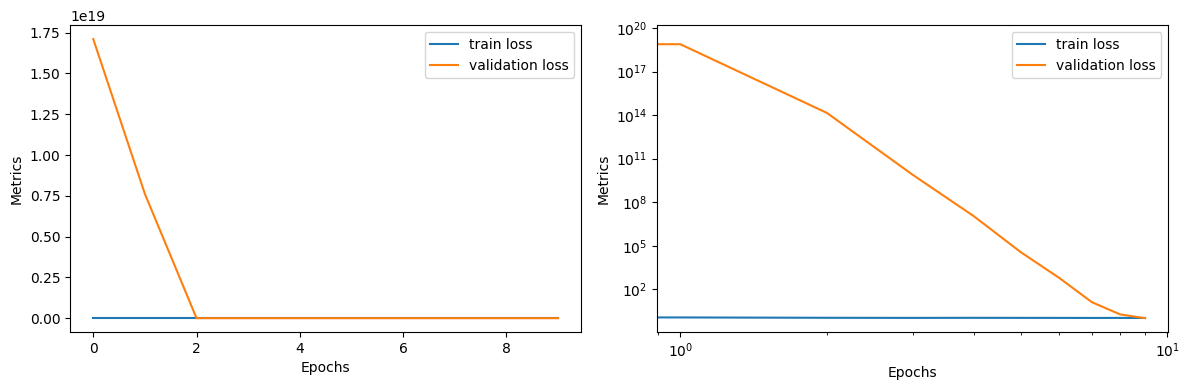

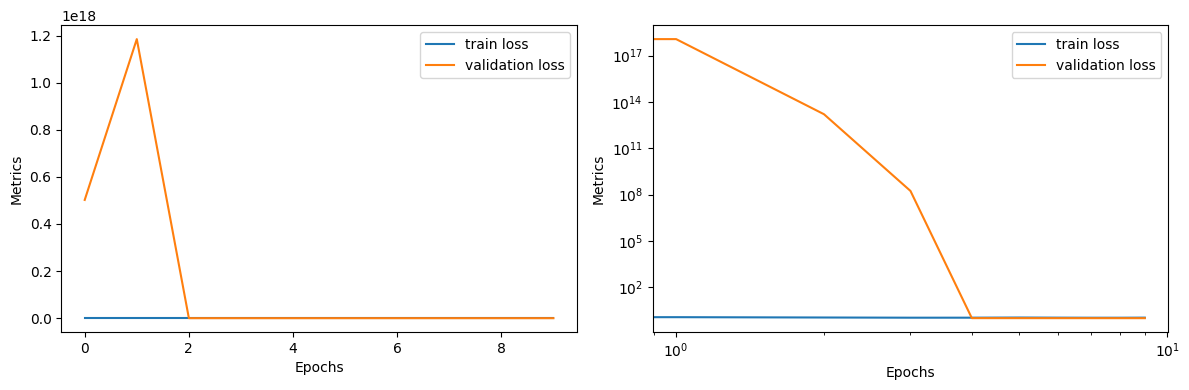

In [11]:
# Plot the loss function over time
plot_history(ann_fp32_history, metrics=["loss"], plot_log=True)
plot_history(ann_bf16_history, metrics=["loss"], plot_log=True)

Importing ANN Training Results from our Runs with 100 EPOCHS on Kestrel

In [15]:
from collections import deque
import tarfile
import os

dir_name = 'mixed_precision_outputs'

if not os.path.exists(dir_name):
    with tarfile.open(dir_name + ".tar") as tar:
        tar.extractall()

with open(dir_name + '/logs/ANN_Training_Summary_CPU.out', 'r') as file:
    last_lines = deque(file, maxlen=11)
    print(''.join(list(last_lines)[:-2]))

ANN Training Summary on CPU
FP32 training time: 4273.236 seconds with loss: 1.05089271068573
BF16 training time: 2625.727 seconds with loss: 1.0568592548370361
FP32 total consumed energy: 0.93038 J with emissions: 0.34248 kgCO2
BF16 total consumed energy: 0.56905 J with emissions: 0.20947 kgCO2
FP32 EDP (Energy Delay Product): 3975.754 J*s
BF16 EDP (Energy Delay Product): 1494.178 J*s
BF16 is 1.63X faster than FP32 with -0.01% accuracy loss
BF16 reduces emissions by 38.84% and EDP by 62.42% than FP32



### ResNET Training

In [16]:
# Train ResNET model and acquire training times
print("Training ResNET model with FP32")
resnet_fp32_history, resnet_fp32_training_time, resnet_fp32_emissions, resnet_fp32_total_energy = trainModel(x_train, y_train, x_val, y_val, resnet_model, dataType="fp32")

Training ResNET model with FP32
Model: "residual_neural_network"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_dropout (Dropout)     multiple                  0         
                                                                 
 output (DefaultOutput)      multiple                  40010     
                                                                 
 residual_block (ResidualBl  multiple                  801000000 
 ock)                                                            
                                                                 
Total params: 801040010 (2.98 GB)
Trainable params: 800640010 (2.98 GB)
Non-trainable params: 400000 (1.53 MB)
_________________________________________________________________
Model: "output"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 output (Dense) 

 activation_49 (Activation)  multiple                  0         
                                                                 
 dropout_0 (Dropout)         multiple                  0         
                                                                 
 dropout_1 (Dropout)         multiple                  0         
                                                                 
 dropout_2 (Dropout)         multiple                  0         
                                                                 
 dropout_3 (Dropout)         multiple                  0         
                                                                 
 dropout_4 (Dropout)         multiple                  0         
                                                                 
 dropout_5 (Dropout)         multiple                  0         
                                                                 
 dropout_6 (Dropout)         multiple                  0         
          

                                                                 
 batch_norm_8 (BatchNormali  multiple                  16000     
 zation)                                                         
                                                                 
 batch_norm_9 (BatchNormali  multiple                  16000     
 zation)                                                         
                                                                 
 batch_norm_10 (BatchNormal  multiple                  16000     
 ization)                                                        
                                                                 
 batch_norm_11 (BatchNormal  multiple                  16000     
 ization)                                                        
                                                                 
 batch_norm_12 (BatchNormal  multiple                  16000     
 ization)                                                        
          

 ization)                                                        
                                                                 
 dense_0 (Dense)             multiple                  16004000  
                                                                 
 dense_1 (Dense)             multiple                  16004000  
                                                                 
 dense_2 (Dense)             multiple                  16004000  
                                                                 
 dense_3 (Dense)             multiple                  16004000  
                                                                 
 dense_4 (Dense)             multiple                  16004000  
                                                                 
 dense_5 (Dense)             multiple                  16004000  
                                                                 
 dense_6 (Dense)             multiple                  16004000  
          

                                                                 
 add_12 (Add)                multiple                  0         
                                                                 
 add_13 (Add)                multiple                  0         
                                                                 
 add_14 (Add)                multiple                  0         
                                                                 
 add_15 (Add)                multiple                  0         
                                                                 
 add_16 (Add)                multiple                  0         
                                                                 
 add_17 (Add)                multiple                  0         
                                                                 
 add_18 (Add)                multiple                  0         
                                                                 
 add_19 (A

[codecarbon INFO @ 11:48:46] [setup] RAM Tracking...
[codecarbon INFO @ 11:48:46] [setup] GPU Tracking...
[codecarbon INFO @ 11:48:46] No GPU found.
[codecarbon INFO @ 11:48:46] [setup] CPU Tracking...
[codecarbon INFO @ 11:48:46] Tracking Intel CPU via RAPL interface
[codecarbon INFO @ 11:48:47] >>> Tracker's metadata:
[codecarbon INFO @ 11:48:47]   Platform system: Linux-4.18.0-477.10.1.el8_8.x86_64-x86_64-with-glibc2.28
[codecarbon INFO @ 11:48:47]   Python version: 3.11.9
[codecarbon INFO @ 11:48:47]   CodeCarbon version: 2.5.0
[codecarbon INFO @ 11:48:47]   Available RAM : 246.064 GB
[codecarbon INFO @ 11:48:47]   CPU count: 104
[codecarbon INFO @ 11:48:47]   CPU model: Intel(R) Xeon(R) Platinum 8470QL
[codecarbon INFO @ 11:48:47]   GPU count: None
[codecarbon INFO @ 11:48:47]   GPU model: None
[codecarbon INFO @ 11:48:50] Saving emissions data to file /home/ttahmid/applications_test/AI/supervised/regression/emissions.csv


Epoch 1/10
 1/10 [==>...........................] - ETA: 2:02 - loss: 5.3878

[codecarbon INFO @ 11:49:05] Energy consumed for RAM : 0.000384 kWh. RAM Power : 92.27400000000002 W
[codecarbon INFO @ 11:49:05] Energy consumed for all CPUs : 0.002071 kWh. Total CPU Power : 496.97936600508456 W
[codecarbon INFO @ 11:49:05] 0.002456 kWh of electricity used since the beginning.


 4/10 [===========>..................] - ETA: 23s - loss: 72.6649

[codecarbon INFO @ 11:49:20] Energy consumed for RAM : 0.000769 kWh. RAM Power : 92.27400000000002 W
[codecarbon INFO @ 11:49:20] Energy consumed for all CPUs : 0.004978 kWh. Total CPU Power : 697.5235287363562 W
[codecarbon INFO @ 11:49:20] 0.005747 kWh of electricity used since the beginning.


 8/10 [=======================>......] - ETA: 7s - loss: 41.2008 

[codecarbon INFO @ 11:49:35] Energy consumed for RAM : 0.001154 kWh. RAM Power : 92.27400000000002 W
[codecarbon INFO @ 11:49:35] Energy consumed for all CPUs : 0.007881 kWh. Total CPU Power : 696.2710327509387 W
[codecarbon INFO @ 11:49:35] 0.009035 kWh of electricity used since the beginning.


10/10 [==============================] - 51s 4s/step - loss: 34.3046 - val_loss: 125618979057912668221341696.0000
Epoch 2/10
 2/10 [=====>........................] - ETA: 31s - loss: 2.6882

[codecarbon INFO @ 11:49:50] Energy consumed for RAM : 0.001538 kWh. RAM Power : 92.27400000000002 W
[codecarbon INFO @ 11:49:50] Energy consumed for all CPUs : 0.010721 kWh. Total CPU Power : 681.4777497105849 W
[codecarbon INFO @ 11:49:50] 0.012259 kWh of electricity used since the beginning.


 5/10 [==============>...............] - ETA: 20s - loss: 2.5347

[codecarbon INFO @ 11:50:05] Energy consumed for RAM : 0.001923 kWh. RAM Power : 92.27400000000002 W
[codecarbon INFO @ 11:50:05] Energy consumed for all CPUs : 0.013627 kWh. Total CPU Power : 697.3206764716449 W
[codecarbon INFO @ 11:50:05] 0.015549 kWh of electricity used since the beginning.


 9/10 [==========================>...] - ETA: 4s - loss: 2.2401

[codecarbon INFO @ 11:50:20] Energy consumed for RAM : 0.002307 kWh. RAM Power : 92.27400000000002 W
[codecarbon INFO @ 11:50:20] Energy consumed for all CPUs : 0.016515 kWh. Total CPU Power : 693.1705070432749 W
[codecarbon INFO @ 11:50:20] 0.018822 kWh of electricity used since the beginning.


10/10 [==============================] - 41s 4s/step - loss: 2.1853 - val_loss: 4451397935715283334332416.0000
Epoch 3/10
 2/10 [=====>........................] - ETA: 32s - loss: 1.6393

[codecarbon INFO @ 11:50:35] Energy consumed for RAM : 0.002692 kWh. RAM Power : 92.27400000000002 W
[codecarbon INFO @ 11:50:35] Energy consumed for all CPUs : 0.019417 kWh. Total CPU Power : 696.0305428063115 W
[codecarbon INFO @ 11:50:35] 0.022109 kWh of electricity used since the beginning.


 6/10 [=================>............] - ETA: 16s - loss: 1.5753

[codecarbon INFO @ 11:50:50] Energy consumed for RAM : 0.003076 kWh. RAM Power : 92.27400000000002 W
[codecarbon INFO @ 11:50:50] Energy consumed for all CPUs : 0.022295 kWh. Total CPU Power : 690.9005575526041 W
[codecarbon INFO @ 11:50:50] 0.025371 kWh of electricity used since the beginning.
[codecarbon ERROR @ 11:50:50] Region:  not found for Country with ISO CODE : USA
Traceback (most recent call last):
  File "/home/ttahmid/.conda-envs/tf-melt/lib/python3.11/site-packages/codecarbon/core/emissions.py", line 142, in get_private_infra_emissions
    return self.get_region_emissions(energy, geo)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/ttahmid/.conda-envs/tf-melt/lib/python3.11/site-packages/codecarbon/core/emissions.py", line 168, in get_region_emissions
    raise ValueError(
ValueError: Region:  not found for Country with ISO CODE : USA
[codecarbon WARNING @ 11:50:50] Regional emissions retrieval failed. Falling back on country emissions.
[codecarbon INFO @ 1

10/10 [==============================] - ETA: 0s - loss: 1.5673

[codecarbon INFO @ 11:51:05] Energy consumed for RAM : 0.003460 kWh. RAM Power : 92.27400000000002 W
[codecarbon INFO @ 11:51:05] Energy consumed for all CPUs : 0.025185 kWh. Total CPU Power : 693.5606864263602 W
[codecarbon INFO @ 11:51:05] 0.028645 kWh of electricity used since the beginning.


10/10 [==============================] - 43s 4s/step - loss: 1.5673 - val_loss: 498648824579111256064.0000
Epoch 4/10
 3/10 [========>.....................] - ETA: 28s - loss: 1.5412

[codecarbon INFO @ 11:51:20] Energy consumed for RAM : 0.003845 kWh. RAM Power : 92.27400000000002 W
[codecarbon INFO @ 11:51:20] Energy consumed for all CPUs : 0.028070 kWh. Total CPU Power : 692.300751486075 W
[codecarbon INFO @ 11:51:20] 0.031914 kWh of electricity used since the beginning.


 7/10 [====================>.........] - ETA: 11s - loss: 1.5460

[codecarbon INFO @ 11:51:35] Energy consumed for RAM : 0.004229 kWh. RAM Power : 92.27400000000002 W
[codecarbon INFO @ 11:51:35] Energy consumed for all CPUs : 0.030966 kWh. Total CPU Power : 695.1329245126301 W
[codecarbon INFO @ 11:51:35] 0.035195 kWh of electricity used since the beginning.


10/10 [==============================] - 41s 4s/step - loss: 1.5269 - val_loss: 181751694432927744.0000
Epoch 5/10


[codecarbon INFO @ 11:51:50] Energy consumed for RAM : 0.004613 kWh. RAM Power : 92.27400000000002 W
[codecarbon INFO @ 11:51:50] Energy consumed for all CPUs : 0.033864 kWh. Total CPU Power : 695.7752408960728 W
[codecarbon INFO @ 11:51:50] 0.038477 kWh of electricity used since the beginning.


 4/10 [===========>..................] - ETA: 26s - loss: 1.4553

[codecarbon INFO @ 11:52:05] Energy consumed for RAM : 0.004998 kWh. RAM Power : 92.27400000000002 W
[codecarbon INFO @ 11:52:05] Energy consumed for all CPUs : 0.036744 kWh. Total CPU Power : 691.650521449711 W
[codecarbon INFO @ 11:52:05] 0.041742 kWh of electricity used since the beginning.


 8/10 [=======================>......] - ETA: 8s - loss: 1.4642 

[codecarbon INFO @ 11:52:20] Energy consumed for RAM : 0.005382 kWh. RAM Power : 92.27400000000002 W
[codecarbon INFO @ 11:52:20] Energy consumed for all CPUs : 0.039645 kWh. Total CPU Power : 696.1415937160239 W
[codecarbon INFO @ 11:52:20] 0.045027 kWh of electricity used since the beginning.


10/10 [==============================] - 42s 4s/step - loss: 1.4657 - val_loss: 214388006977536.0000
Epoch 6/10
 1/10 [==>...........................] - ETA: 41s - loss: 1.4118

[codecarbon INFO @ 11:52:35] Energy consumed for RAM : 0.005767 kWh. RAM Power : 92.27400000000002 W
[codecarbon INFO @ 11:52:35] Energy consumed for all CPUs : 0.042519 kWh. Total CPU Power : 689.6403988846239 W
[codecarbon INFO @ 11:52:35] 0.048286 kWh of electricity used since the beginning.


 5/10 [==============>...............] - ETA: 19s - loss: 1.4771

[codecarbon INFO @ 11:52:50] Energy consumed for RAM : 0.006151 kWh. RAM Power : 92.27400000000002 W
[codecarbon INFO @ 11:52:50] Energy consumed for all CPUs : 0.045421 kWh. Total CPU Power : 696.6016297612193 W
[codecarbon INFO @ 11:52:50] 0.051572 kWh of electricity used since the beginning.
[codecarbon ERROR @ 11:52:50] Region:  not found for Country with ISO CODE : USA
Traceback (most recent call last):
  File "/home/ttahmid/.conda-envs/tf-melt/lib/python3.11/site-packages/codecarbon/core/emissions.py", line 142, in get_private_infra_emissions
    return self.get_region_emissions(energy, geo)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/ttahmid/.conda-envs/tf-melt/lib/python3.11/site-packages/codecarbon/core/emissions.py", line 168, in get_region_emissions
    raise ValueError(
ValueError: Region:  not found for Country with ISO CODE : USA
[codecarbon WARNING @ 11:52:50] Regional emissions retrieval failed. Falling back on country emissions.
[codecarbon INFO @ 1

 9/10 [==========================>...] - ETA: 3s - loss: 1.4563

[codecarbon INFO @ 11:53:05] Energy consumed for RAM : 0.006535 kWh. RAM Power : 92.27400000000002 W
[codecarbon INFO @ 11:53:05] Energy consumed for all CPUs : 0.048325 kWh. Total CPU Power : 697.1837293933365 W
[codecarbon INFO @ 11:53:05] 0.054861 kWh of electricity used since the beginning.


10/10 [==============================] - 41s 4s/step - loss: 1.4491 - val_loss: 648481734656.0000
Epoch 7/10
 2/10 [=====>........................] - ETA: 32s - loss: 1.4673

[codecarbon INFO @ 11:53:20] Energy consumed for RAM : 0.006920 kWh. RAM Power : 92.27400000000002 W
[codecarbon INFO @ 11:53:20] Energy consumed for all CPUs : 0.051209 kWh. Total CPU Power : 691.7110100226002 W
[codecarbon INFO @ 11:53:20] 0.058129 kWh of electricity used since the beginning.


 6/10 [=================>............] - ETA: 15s - loss: 1.4372

[codecarbon INFO @ 11:53:35] Energy consumed for RAM : 0.007304 kWh. RAM Power : 92.27400000000002 W
[codecarbon INFO @ 11:53:35] Energy consumed for all CPUs : 0.054097 kWh. Total CPU Power : 693.0555723248108 W
[codecarbon INFO @ 11:53:35] 0.061401 kWh of electricity used since the beginning.


10/10 [==============================] - ETA: 0s - loss: 1.4172

[codecarbon INFO @ 11:53:50] Energy consumed for RAM : 0.007689 kWh. RAM Power : 92.27400000000002 W
[codecarbon INFO @ 11:53:50] Energy consumed for all CPUs : 0.056998 kWh. Total CPU Power : 695.7054891836077 W
[codecarbon INFO @ 11:53:50] 0.064687 kWh of electricity used since the beginning.


10/10 [==============================] - 41s 4s/step - loss: 1.4172 - val_loss: 3331787264.0000
Epoch 8/10
 3/10 [========>.....................] - ETA: 28s - loss: 1.3820

[codecarbon INFO @ 11:54:05] Energy consumed for RAM : 0.008074 kWh. RAM Power : 92.27400000000002 W
[codecarbon INFO @ 11:54:05] Energy consumed for all CPUs : 0.059887 kWh. Total CPU Power : 692.9756247036224 W
[codecarbon INFO @ 11:54:05] 0.067961 kWh of electricity used since the beginning.


 7/10 [====================>.........] - ETA: 11s - loss: 1.4049

[codecarbon INFO @ 11:54:20] Energy consumed for RAM : 0.008458 kWh. RAM Power : 92.27400000000002 W
[codecarbon INFO @ 11:54:20] Energy consumed for all CPUs : 0.062787 kWh. Total CPU Power : 696.0566246185692 W
[codecarbon INFO @ 11:54:20] 0.071245 kWh of electricity used since the beginning.


10/10 [==============================] - 41s 4s/step - loss: 1.3901 - val_loss: 27108268.0000
Epoch 9/10


[codecarbon INFO @ 11:54:35] Energy consumed for RAM : 0.008843 kWh. RAM Power : 92.27400000000002 W
[codecarbon INFO @ 11:54:35] Energy consumed for all CPUs : 0.065693 kWh. Total CPU Power : 697.4190942083421 W
[codecarbon INFO @ 11:54:35] 0.074535 kWh of electricity used since the beginning.


 4/10 [===========>..................] - ETA: 23s - loss: 1.3865

[codecarbon INFO @ 11:54:50] Energy consumed for RAM : 0.009227 kWh. RAM Power : 92.27400000000002 W
[codecarbon INFO @ 11:54:50] Energy consumed for all CPUs : 0.068585 kWh. Total CPU Power : 694.2045349434641 W
[codecarbon INFO @ 11:54:50] 0.077812 kWh of electricity used since the beginning.
[codecarbon ERROR @ 11:54:50] Region:  not found for Country with ISO CODE : USA
Traceback (most recent call last):
  File "/home/ttahmid/.conda-envs/tf-melt/lib/python3.11/site-packages/codecarbon/core/emissions.py", line 142, in get_private_infra_emissions
    return self.get_region_emissions(energy, geo)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/ttahmid/.conda-envs/tf-melt/lib/python3.11/site-packages/codecarbon/core/emissions.py", line 168, in get_region_emissions
    raise ValueError(
ValueError: Region:  not found for Country with ISO CODE : USA
[codecarbon WARNING @ 11:54:50] Regional emissions retrieval failed. Falling back on country emissions.
[codecarbon INFO @ 1

 8/10 [=======================>......] - ETA: 8s - loss: 1.3763 

[codecarbon INFO @ 11:55:05] Energy consumed for RAM : 0.009611 kWh. RAM Power : 92.27400000000002 W
[codecarbon INFO @ 11:55:05] Energy consumed for all CPUs : 0.071468 kWh. Total CPU Power : 692.086135268809 W
[codecarbon INFO @ 11:55:05] 0.081080 kWh of electricity used since the beginning.


10/10 [==============================] - 41s 4s/step - loss: 1.3801 - val_loss: 251716.9219
Epoch 10/10
 2/10 [=====>........................] - ETA: 29s - loss: 1.3696

[codecarbon INFO @ 11:55:20] Energy consumed for RAM : 0.009996 kWh. RAM Power : 92.27400000000002 W
[codecarbon INFO @ 11:55:20] Energy consumed for all CPUs : 0.074383 kWh. Total CPU Power : 699.1095155801667 W
[codecarbon INFO @ 11:55:20] 0.084379 kWh of electricity used since the beginning.


 5/10 [==============>...............] - ETA: 20s - loss: 1.3857

[codecarbon INFO @ 11:55:35] Energy consumed for RAM : 0.010380 kWh. RAM Power : 92.27400000000002 W
[codecarbon INFO @ 11:55:35] Energy consumed for all CPUs : 0.077267 kWh. Total CPU Power : 691.9528827083775 W
[codecarbon INFO @ 11:55:35] 0.087647 kWh of electricity used since the beginning.


 9/10 [==========================>...] - ETA: 3s - loss: 1.3868

[codecarbon INFO @ 11:55:50] Energy consumed for RAM : 0.010765 kWh. RAM Power : 92.27400000000002 W
[codecarbon INFO @ 11:55:50] Energy consumed for all CPUs : 0.080161 kWh. Total CPU Power : 694.695864326249 W
[codecarbon INFO @ 11:55:50] 0.090926 kWh of electricity used since the beginning.


10/10 [==============================] - 41s 4s/step - loss: 1.3849 - val_loss: 12982.4639


[codecarbon INFO @ 11:55:53] Energy consumed for RAM : 0.010851 kWh. RAM Power : 92.27400000000002 W
[codecarbon INFO @ 11:55:53] Energy consumed for all CPUs : 0.080807 kWh. Total CPU Power : 690.8065782488875 W
[codecarbon INFO @ 11:55:53] 0.091658 kWh of electricity used since the beginning.
[codecarbon ERROR @ 11:55:53] Region:  not found for Country with ISO CODE : USA
Traceback (most recent call last):
  File "/home/ttahmid/.conda-envs/tf-melt/lib/python3.11/site-packages/codecarbon/core/emissions.py", line 142, in get_private_infra_emissions
    return self.get_region_emissions(energy, geo)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/ttahmid/.conda-envs/tf-melt/lib/python3.11/site-packages/codecarbon/core/emissions.py", line 168, in get_region_emissions
    raise ValueError(
ValueError: Region:  not found for Country with ISO CODE : USA
[codecarbon WARNING @ 11:55:53] Regional emissions retrieval failed. Falling back on country emissions.


Training took 423.470 seconds


/home/ttahmid/.conda-envs/tf-melt/lib/python3.11/site-packages/codecarbon/output_methods/file.py:53: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, pd.DataFrame.from_records([dict(total.values)])])


In [17]:
print("Training ResNET model with BF16")
resnet_bf16_history, resnet_bf16_training_time, resnet_bf16_emissions, resnet_bf16_total_energy = trainModel(x_train, y_train, x_val, y_val, resnet_model, dataType="bf16")

Training ResNET model with BF16
Enabling Mixed Precision (mixed_bfloat16) with AMX
Model: "residual_neural_network"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_dropout (Dropout)     multiple                  0         
                                                                 
 output (DefaultOutput)      multiple                  40010     
                                                                 
 residual_block (ResidualBl  multiple                  801000000 
 ock)                                                            
                                                                 
Total params: 801040010 (2.98 GB)
Trainable params: 800640010 (2.98 GB)
Non-trainable params: 400000 (1.53 MB)
_________________________________________________________________
Model: "output"
_________________________________________________________________
 Layer (type)                Ou

                                                                 
 activation_49 (Activation)  multiple                  0         
                                                                 
 dropout_0 (Dropout)         multiple                  0         
                                                                 
 dropout_1 (Dropout)         multiple                  0         
                                                                 
 dropout_2 (Dropout)         multiple                  0         
                                                                 
 dropout_3 (Dropout)         multiple                  0         
                                                                 
 dropout_4 (Dropout)         multiple                  0         
                                                                 
 dropout_5 (Dropout)         multiple                  0         
                                                                 
 dropout_6

 zation)                                                         
                                                                 
 batch_norm_8 (BatchNormali  multiple                  16000     
 zation)                                                         
                                                                 
 batch_norm_9 (BatchNormali  multiple                  16000     
 zation)                                                         
                                                                 
 batch_norm_10 (BatchNormal  multiple                  16000     
 ization)                                                        
                                                                 
 batch_norm_11 (BatchNormal  multiple                  16000     
 ization)                                                        
                                                                 
 batch_norm_12 (BatchNormal  multiple                  16000     
 ization) 

 batch_norm_49 (BatchNormal  multiple                  16000     
 ization)                                                        
                                                                 
 dense_0 (Dense)             multiple                  16004000  
                                                                 
 dense_1 (Dense)             multiple                  16004000  
                                                                 
 dense_2 (Dense)             multiple                  16004000  
                                                                 
 dense_3 (Dense)             multiple                  16004000  
                                                                 
 dense_4 (Dense)             multiple                  16004000  
                                                                 
 dense_5 (Dense)             multiple                  16004000  
                                                                 
 dense_6 (

 add_11 (Add)                multiple                  0         
                                                                 
 add_12 (Add)                multiple                  0         
                                                                 
 add_13 (Add)                multiple                  0         
                                                                 
 add_14 (Add)                multiple                  0         
                                                                 
 add_15 (Add)                multiple                  0         
                                                                 
 add_16 (Add)                multiple                  0         
                                                                 
 add_17 (Add)                multiple                  0         
                                                                 
 add_18 (Add)                multiple                  0         
          

                                                                 
 activation_41 (Activation)  multiple                  0         
                                                                 
 activation_42 (Activation)  multiple                  0         
                                                                 
 activation_43 (Activation)  multiple                  0         
                                                                 
 activation_44 (Activation)  multiple                  0         
                                                                 
 activation_45 (Activation)  multiple                  0         
                                                                 
 activation_46 (Activation)  multiple                  0         
                                                                 
 activation_47 (Activation)  multiple                  0         
                                                                 
 activatio

 batch_norm_2 (BatchNormali  multiple                  16000     
 zation)                                                         
                                                                 
 batch_norm_3 (BatchNormali  multiple                  16000     
 zation)                                                         
                                                                 
 batch_norm_4 (BatchNormali  multiple                  16000     
 zation)                                                         
                                                                 
 batch_norm_5 (BatchNormali  multiple                  16000     
 zation)                                                         
                                                                 
 batch_norm_6 (BatchNormali  multiple                  16000     
 zation)                                                         
                                                                 
 batch_nor

                                                                 
 batch_norm_44 (BatchNormal  multiple                  16000     
 ization)                                                        
                                                                 
 batch_norm_45 (BatchNormal  multiple                  16000     
 ization)                                                        
                                                                 
 batch_norm_46 (BatchNormal  multiple                  16000     
 ization)                                                        
                                                                 
 batch_norm_47 (BatchNormal  multiple                  16000     
 ization)                                                        
                                                                 
 batch_norm_48 (BatchNormal  multiple                  16000     
 ization)                                                        
          

 add_3 (Add)                 multiple                  0         
                                                                 
 add_4 (Add)                 multiple                  0         
                                                                 
 add_5 (Add)                 multiple                  0         
                                                                 
 add_6 (Add)                 multiple                  0         
                                                                 
 add_7 (Add)                 multiple                  0         
                                                                 
 add_8 (Add)                 multiple                  0         
                                                                 
 add_9 (Add)                 multiple                  0         
                                                                 
 add_10 (Add)                multiple                  0         
          

[codecarbon INFO @ 11:56:02] [setup] RAM Tracking...
[codecarbon INFO @ 11:56:02] [setup] GPU Tracking...
[codecarbon INFO @ 11:56:02] No GPU found.
[codecarbon INFO @ 11:56:02] [setup] CPU Tracking...
[codecarbon INFO @ 11:56:02] Tracking Intel CPU via RAPL interface
[codecarbon INFO @ 11:56:02] >>> Tracker's metadata:
[codecarbon INFO @ 11:56:02]   Platform system: Linux-4.18.0-477.10.1.el8_8.x86_64-x86_64-with-glibc2.28
[codecarbon INFO @ 11:56:02]   Python version: 3.11.9
[codecarbon INFO @ 11:56:02]   CodeCarbon version: 2.5.0
[codecarbon INFO @ 11:56:02]   Available RAM : 246.064 GB
[codecarbon INFO @ 11:56:02]   CPU count: 104
[codecarbon INFO @ 11:56:02]   CPU model: Intel(R) Xeon(R) Platinum 8470QL
[codecarbon INFO @ 11:56:02]   GPU count: None
[codecarbon INFO @ 11:56:02]   GPU model: None
[codecarbon INFO @ 11:56:05] Saving emissions data to file /home/ttahmid/applications_test/AI/supervised/regression/emissions.csv


Epoch 1/10


2024-07-23 11:56:16.184148: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:2254] Converted 385/11857 nodes to bfloat16 precision using 104 cast(s) to bfloat16 (excluding Const and Variable casts)
[codecarbon INFO @ 11:56:20] Energy consumed for RAM : 0.000385 kWh. RAM Power : 92.27400000000002 W
[codecarbon INFO @ 11:56:20] Energy consumed for all CPUs : 0.001839 kWh. Total CPU Power : 441.287222015896 W
[codecarbon INFO @ 11:56:20] 0.002223 kWh of electricity used since the beginning.


 7/10 [====================>.........] - ETA: 6s - loss: 37.5024

[codecarbon INFO @ 11:56:35] Energy consumed for RAM : 0.000769 kWh. RAM Power : 92.27400000000002 W
[codecarbon INFO @ 11:56:35] Energy consumed for all CPUs : 0.004745 kWh. Total CPU Power : 697.51973210536 W
[codecarbon INFO @ 11:56:35] 0.005514 kWh of electricity used since the beginning.


10/10 [==============================] - ETA: 0s - loss: 28.3440

2024-07-23 11:56:41.615475: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:2254] Converted 278/1167 nodes to bfloat16 precision using 102 cast(s) to bfloat16 (excluding Const and Variable casts)


10/10 [==============================] - 36s 2s/step - loss: 28.3440 - val_loss: 209963054656250961639505920.0000
Epoch 2/10
 3/10 [========>.....................] - ETA: 15s - loss: 5.6380

[codecarbon INFO @ 11:56:50] Energy consumed for RAM : 0.001153 kWh. RAM Power : 92.27400000000002 W
[codecarbon INFO @ 11:56:50] Energy consumed for all CPUs : 0.007587 kWh. Total CPU Power : 681.9071654600982 W
[codecarbon INFO @ 11:56:50] 0.008740 kWh of electricity used since the beginning.


10/10 [==============================] - ETA: 0s - loss: 3.3338

[codecarbon INFO @ 11:57:05] Energy consumed for RAM : 0.001538 kWh. RAM Power : 92.27400000000002 W
[codecarbon INFO @ 11:57:05] Energy consumed for all CPUs : 0.010476 kWh. Total CPU Power : 693.6661709654161 W
[codecarbon INFO @ 11:57:05] 0.012014 kWh of electricity used since the beginning.


10/10 [==============================] - 23s 2s/step - loss: 3.3338 - val_loss: 10883436041222064204414976.0000
Epoch 3/10
 6/10 [=================>............] - ETA: 9s - loss: 1.6833 

[codecarbon INFO @ 11:57:20] Energy consumed for RAM : 0.001922 kWh. RAM Power : 92.27400000000002 W
[codecarbon INFO @ 11:57:20] Energy consumed for all CPUs : 0.013361 kWh. Total CPU Power : 692.3943874742231 W
[codecarbon INFO @ 11:57:20] 0.015283 kWh of electricity used since the beginning.


10/10 [==============================] - 24s 2s/step - loss: 1.6272 - val_loss: 1833344476608397836288.0000
Epoch 4/10
 2/10 [=====>........................] - ETA: 19s - loss: 1.4870

[codecarbon INFO @ 11:57:35] Energy consumed for RAM : 0.002307 kWh. RAM Power : 92.27400000000002 W
[codecarbon INFO @ 11:57:35] Energy consumed for all CPUs : 0.016239 kWh. Total CPU Power : 690.8123135087077 W
[codecarbon INFO @ 11:57:35] 0.018546 kWh of electricity used since the beginning.


 8/10 [=======================>......] - ETA: 4s - loss: 1.5083

[codecarbon INFO @ 11:57:50] Energy consumed for RAM : 0.002691 kWh. RAM Power : 92.27400000000002 W
[codecarbon INFO @ 11:57:50] Energy consumed for all CPUs : 0.019120 kWh. Total CPU Power : 691.3650808997644 W
[codecarbon INFO @ 11:57:50] 0.021811 kWh of electricity used since the beginning.


10/10 [==============================] - 25s 3s/step - loss: 1.5021 - val_loss: 654401901781057536.0000
Epoch 5/10
 4/10 [===========>..................] - ETA: 14s - loss: 1.4991

[codecarbon INFO @ 11:58:05] Energy consumed for RAM : 0.003075 kWh. RAM Power : 92.27400000000002 W
[codecarbon INFO @ 11:58:05] Energy consumed for all CPUs : 0.021998 kWh. Total CPU Power : 690.7502015696134 W
[codecarbon INFO @ 11:58:05] 0.025073 kWh of electricity used since the beginning.
[codecarbon ERROR @ 11:58:05] Region:  not found for Country with ISO CODE : USA
Traceback (most recent call last):
  File "/home/ttahmid/.conda-envs/tf-melt/lib/python3.11/site-packages/codecarbon/core/emissions.py", line 142, in get_private_infra_emissions
    return self.get_region_emissions(energy, geo)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/ttahmid/.conda-envs/tf-melt/lib/python3.11/site-packages/codecarbon/core/emissions.py", line 168, in get_region_emissions
    raise ValueError(
ValueError: Region:  not found for Country with ISO CODE : USA
[codecarbon WARNING @ 11:58:05] Regional emissions retrieval failed. Falling back on country emissions.
[codecarbon INFO @ 1

 9/10 [==========================>...] - ETA: 2s - loss: 1.4884

[codecarbon INFO @ 11:58:20] Energy consumed for RAM : 0.003460 kWh. RAM Power : 92.27400000000002 W
[codecarbon INFO @ 11:58:20] Energy consumed for all CPUs : 0.024855 kWh. Total CPU Power : 685.6754042764684 W
[codecarbon INFO @ 11:58:20] 0.028315 kWh of electricity used since the beginning.


10/10 [==============================] - 27s 3s/step - loss: 1.4875 - val_loss: 1141971674464256.0000
Epoch 6/10
 5/10 [==============>...............] - ETA: 13s - loss: 1.4696

[codecarbon INFO @ 11:58:35] Energy consumed for RAM : 0.003844 kWh. RAM Power : 92.27400000000002 W
[codecarbon INFO @ 11:58:35] Energy consumed for all CPUs : 0.027722 kWh. Total CPU Power : 687.9729373310664 W
[codecarbon INFO @ 11:58:35] 0.031566 kWh of electricity used since the beginning.


10/10 [==============================] - 28s 3s/step - loss: 1.4395 - val_loss: 1022757634048.0000
Epoch 7/10


[codecarbon INFO @ 11:58:50] Energy consumed for RAM : 0.004229 kWh. RAM Power : 92.27400000000002 W
[codecarbon INFO @ 11:58:50] Energy consumed for all CPUs : 0.030569 kWh. Total CPU Power : 683.6167424654546 W
[codecarbon INFO @ 11:58:50] 0.034798 kWh of electricity used since the beginning.


 5/10 [==============>...............] - ETA: 13s - loss: 1.4182

[codecarbon INFO @ 11:59:05] Energy consumed for RAM : 0.004613 kWh. RAM Power : 92.27400000000002 W
[codecarbon INFO @ 11:59:05] Energy consumed for all CPUs : 0.033430 kWh. Total CPU Power : 686.4546703281702 W
[codecarbon INFO @ 11:59:05] 0.038043 kWh of electricity used since the beginning.


10/10 [==============================] - 28s 3s/step - loss: 1.4249 - val_loss: 6836121600.0000
Epoch 8/10


[codecarbon INFO @ 11:59:20] Energy consumed for RAM : 0.004997 kWh. RAM Power : 92.27400000000002 W
[codecarbon INFO @ 11:59:20] Energy consumed for all CPUs : 0.036298 kWh. Total CPU Power : 687.826374959384 W
[codecarbon INFO @ 11:59:20] 0.041295 kWh of electricity used since the beginning.


 6/10 [=================>............] - ETA: 10s - loss: 1.4135

[codecarbon INFO @ 11:59:35] Energy consumed for RAM : 0.005382 kWh. RAM Power : 92.27400000000002 W
[codecarbon INFO @ 11:59:35] Energy consumed for all CPUs : 0.039154 kWh. Total CPU Power : 685.7966561396383 W
[codecarbon INFO @ 11:59:35] 0.044535 kWh of electricity used since the beginning.


10/10 [==============================] - 28s 3s/step - loss: 1.4068 - val_loss: 134906480.0000
Epoch 9/10
 1/10 [==>...........................] - ETA: 24s - loss: 1.3271

[codecarbon INFO @ 11:59:50] Energy consumed for RAM : 0.005766 kWh. RAM Power : 92.27400000000002 W
[codecarbon INFO @ 11:59:50] Energy consumed for all CPUs : 0.042009 kWh. Total CPU Power : 685.5437827280741 W
[codecarbon INFO @ 11:59:50] 0.047775 kWh of electricity used since the beginning.


 7/10 [====================>.........] - ETA: 8s - loss: 1.4191 

[codecarbon INFO @ 12:00:05] Energy consumed for RAM : 0.006150 kWh. RAM Power : 92.27400000000002 W
[codecarbon INFO @ 12:00:05] Energy consumed for all CPUs : 0.044872 kWh. Total CPU Power : 687.1817768472971 W
[codecarbon INFO @ 12:00:05] 0.051022 kWh of electricity used since the beginning.
[codecarbon ERROR @ 12:00:05] Region:  not found for Country with ISO CODE : USA
Traceback (most recent call last):
  File "/home/ttahmid/.conda-envs/tf-melt/lib/python3.11/site-packages/codecarbon/core/emissions.py", line 142, in get_private_infra_emissions
    return self.get_region_emissions(energy, geo)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/ttahmid/.conda-envs/tf-melt/lib/python3.11/site-packages/codecarbon/core/emissions.py", line 168, in get_region_emissions
    raise ValueError(
ValueError: Region:  not found for Country with ISO CODE : USA
[codecarbon WARNING @ 12:00:05] Regional emissions retrieval failed. Falling back on country emissions.
[codecarbon INFO @ 1

10/10 [==============================] - 27s 3s/step - loss: 1.4285 - val_loss: 4940876.0000
Epoch 10/10
 2/10 [=====>........................] - ETA: 21s - loss: 1.4150

[codecarbon INFO @ 12:00:20] Energy consumed for RAM : 0.006535 kWh. RAM Power : 92.27400000000002 W
[codecarbon INFO @ 12:00:20] Energy consumed for all CPUs : 0.047744 kWh. Total CPU Power : 688.4658759121438 W
[codecarbon INFO @ 12:00:20] 0.054280 kWh of electricity used since the beginning.


 8/10 [=======================>......] - ETA: 5s - loss: 1.3998

[codecarbon INFO @ 12:00:35] Energy consumed for RAM : 0.006919 kWh. RAM Power : 92.27400000000002 W
[codecarbon INFO @ 12:00:35] Energy consumed for all CPUs : 0.050615 kWh. Total CPU Power : 688.8740816888088 W
[codecarbon INFO @ 12:00:35] 0.057534 kWh of electricity used since the beginning.


10/10 [==============================] - 26s 3s/step - loss: 1.4053 - val_loss: 204984.6250


[codecarbon INFO @ 12:00:39] Energy consumed for RAM : 0.007018 kWh. RAM Power : 92.27400000000002 W
[codecarbon INFO @ 12:00:39] Energy consumed for all CPUs : 0.051347 kWh. Total CPU Power : 688.8308769136643 W
[codecarbon INFO @ 12:00:39] 0.058365 kWh of electricity used since the beginning.
[codecarbon ERROR @ 12:00:39] Region:  not found for Country with ISO CODE : USA
Traceback (most recent call last):
  File "/home/ttahmid/.conda-envs/tf-melt/lib/python3.11/site-packages/codecarbon/core/emissions.py", line 142, in get_private_infra_emissions
    return self.get_region_emissions(energy, geo)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/ttahmid/.conda-envs/tf-melt/lib/python3.11/site-packages/codecarbon/core/emissions.py", line 168, in get_region_emissions
    raise ValueError(
ValueError: Region:  not found for Country with ISO CODE : USA
[codecarbon WARNING @ 12:00:39] Regional emissions retrieval failed. Falling back on country emissions.


Training took 273.880 seconds


/home/ttahmid/.conda-envs/tf-melt/lib/python3.11/site-packages/codecarbon/output_methods/file.py:53: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, pd.DataFrame.from_records([dict(total.values)])])


In [18]:
# Training time results with loss and emissions
if amx_supported:
    print("ResNET Training Summary on CPU")
elif tensor_cores:
    print("ResNET Training Summary on GPU")
print(f"FP32 training time: {resnet_fp32_training_time:.3f} seconds with loss: {resnet_fp32_history.history['loss'][-1]}")
print(f"BF16 training time: {resnet_bf16_training_time:.3f} seconds with loss: {resnet_bf16_history.history['loss'][-1]}")
print(f"FP32 total consumed energy: {resnet_fp32_total_energy:.5f} J with emissions: {resnet_fp32_emissions:.5f} kgCO2")
print(f"BF16 total consumed energy: {resnet_bf16_total_energy:.5f} J with emissions: {resnet_bf16_emissions:.5f} kgCO2")
print(f"FP32 EDP (Energy Delay Product): {resnet_fp32_training_time * resnet_fp32_total_energy:.3f} J*s")
print(f"BF16 EDP (Energy Delay Product): {resnet_bf16_training_time * resnet_bf16_total_energy:.3f} J*s")

# Calculate speedup of FP16 and BF16 over FP32
resnet_bf16_speedup_from_fp32 = resnet_fp32_training_time / resnet_bf16_training_time
resnet_accuracy_loss = (resnet_fp32_history.history['loss'][-1] - resnet_bf16_history.history['loss'][-1]) / resnet_fp32_history.history['loss'][-1]
print(f"BF16 is {resnet_bf16_speedup_from_fp32:.2f}X faster than FP32 with {resnet_accuracy_loss:.2f}% accuracy loss")
# Calcualte the emissions and EDP reduction percentage
resnet_emissions_reduction = ((resnet_fp32_emissions - resnet_bf16_emissions) / resnet_fp32_emissions) * 100
resnet_edp_reduction = (((resnet_fp32_training_time * resnet_fp32_total_energy) - (resnet_bf16_training_time * resnet_bf16_total_energy)) / (resnet_fp32_training_time * resnet_fp32_total_energy)) * 100
print(f"BF16 reduces emissions by {resnet_emissions_reduction:.2f}% and EDP by {resnet_edp_reduction:.2f}% than FP32")

ResNET Training Summary on CPU
FP32 training time: 423.470 seconds with loss: 1.3848520517349243
BF16 training time: 273.880 seconds with loss: 1.4053150415420532
FP32 total consumed energy: 0.09166 J with emissions: 0.03374 kgCO2
BF16 total consumed energy: 0.05837 J with emissions: 0.02148 kgCO2
FP32 EDP (Energy Delay Product): 38.814 J*s
BF16 EDP (Energy Delay Product): 15.985 J*s
BF16 is 1.55X faster than FP32 with -0.01% accuracy loss
BF16 reduces emissions by 36.32% and EDP by 58.82% than FP32


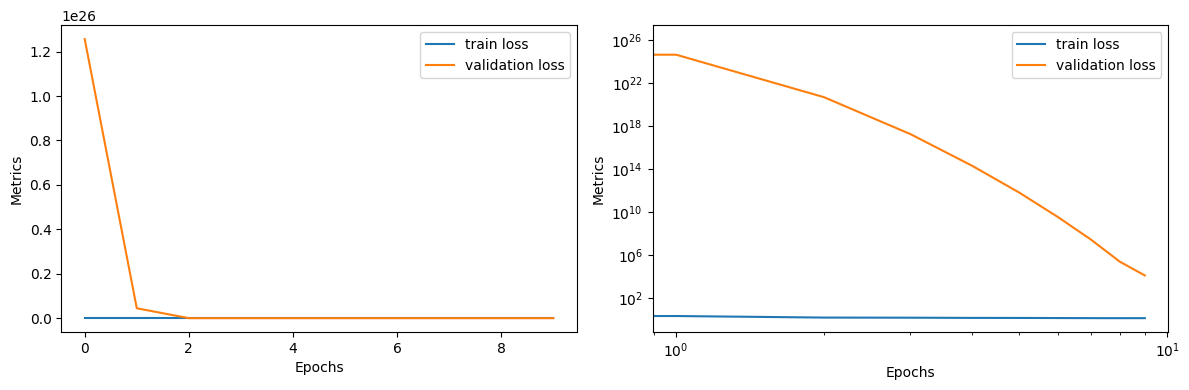

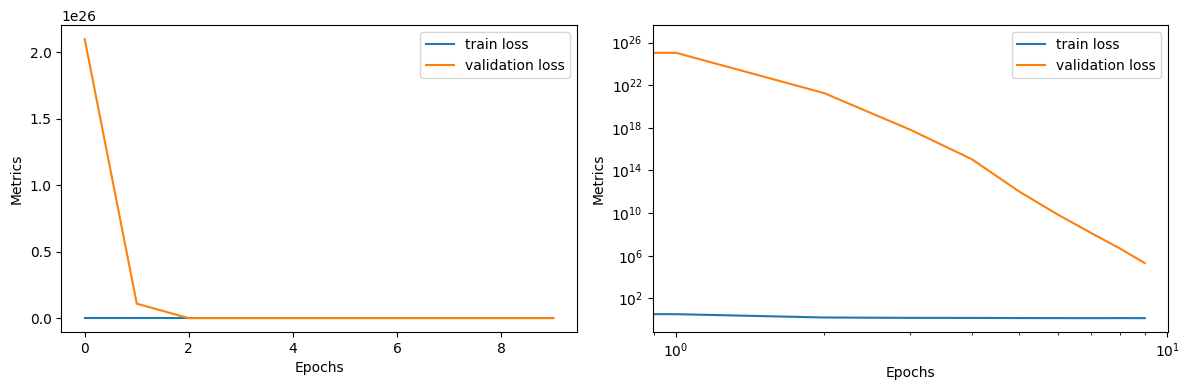

In [19]:
# Plot the loss function over time
plot_history(resnet_fp32_history, metrics=["loss"], plot_log=True)
plot_history(resnet_bf16_history, metrics=["loss"], plot_log=True)

Importing ResNET Training Results of Runs with 100 EPOCHS

In [21]:
from collections import deque
import tarfile
import os

dir_name = 'mixed_precision_outputs'

if not os.path.exists(dir_name):
    with tarfile.open(dir_name + ".tar") as tar:
        tar.extractall()

with open(dir_name + '/logs/ResNet_Training_Summary_CPU.out', 'r') as file:
    last_lines = deque(file, maxlen=11)
    print(''.join(list(last_lines)[:-2]))

ResNet Training Summary on CPU
FP32 training time: 4164.964 seconds with loss: 0.5945581197738647
BF16 training time: 2619.349 seconds with loss: 0.7515238523483276
FP32 total consumed energy: 0.90843 J with emissions: 0.33440 kgCO2
BF16 total consumed energy: 0.56097 J with emissions: 0.20649 kgCO2
FP32 EDP (Energy Delay Product): 3783.591 J*s
BF16 EDP (Energy Delay Product): 1469.366 J*s
BF16 is 1.59X faster than FP32 with -0.26% accuracy loss
BF16 reduces emissions by 38.25% and EDP by 61.16% than FP32



### BNN Training

In [22]:
# Train models and acquire training times, and emissions
print("Training model with FP32")
bnn_fp32_history, bnn_fp32_training_time, bnn_fp32_emissions, bnn_fp32_total_energy = trainModel(x_train, y_train, x_val, y_val, bnn_model, dataType="fp32")

Training model with FP32


/home/ttahmid/.conda-envs/tf-melt/lib/python3.11/site-packages/tensorflow_probability/python/layers/util.py:98: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  loc = add_variable_fn(
/home/ttahmid/.conda-envs/tf-melt/lib/python3.11/site-packages/tensorflow_probability/python/layers/util.py:108: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  untransformed_scale = add_variable_fn(


Model: "bayesian_neural_network"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_dropout (Dropout)     multiple                  0         
                                                                 
 output (DefaultOutput)      multiple                  20490     
                                                                 
 bayesian_block_0 (Bayesian  multiple                  168297120 
 Block)                                                          
                                                                 
Total params: 168317610 (642.08 MB)
Trainable params: 168275562 (641.92 MB)
Non-trainable params: 42048 (164.25 KB)
_________________________________________________________________
Model: "output"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bayesian_output (DenseFlip  multiple      

[codecarbon INFO @ 12:02:32] [setup] RAM Tracking...
[codecarbon INFO @ 12:02:32] [setup] GPU Tracking...
[codecarbon INFO @ 12:02:32] No GPU found.
[codecarbon INFO @ 12:02:32] [setup] CPU Tracking...
[codecarbon INFO @ 12:02:32] Tracking Intel CPU via RAPL interface
[codecarbon INFO @ 12:02:32] >>> Tracker's metadata:
[codecarbon INFO @ 12:02:32]   Platform system: Linux-4.18.0-477.10.1.el8_8.x86_64-x86_64-with-glibc2.28
[codecarbon INFO @ 12:02:32]   Python version: 3.11.9
[codecarbon INFO @ 12:02:32]   CodeCarbon version: 2.5.0
[codecarbon INFO @ 12:02:32]   Available RAM : 246.064 GB
[codecarbon INFO @ 12:02:32]   CPU count: 104
[codecarbon INFO @ 12:02:32]   CPU model: Intel(R) Xeon(R) Platinum 8470QL
[codecarbon INFO @ 12:02:32]   GPU count: None
[codecarbon INFO @ 12:02:32]   GPU model: None
[codecarbon INFO @ 12:02:35] Saving emissions data to file /home/ttahmid/applications_test/AI/supervised/regression/emissions.csv


Epoch 1/10
10/10 [==============================] - 13s 1s/step - loss: 5325.7905 - val_loss: 85293.6484
Epoch 2/10


[codecarbon INFO @ 12:02:50] Energy consumed for RAM : 0.000385 kWh. RAM Power : 92.27400000000002 W
[codecarbon INFO @ 12:02:50] Energy consumed for all CPUs : 0.002593 kWh. Total CPU Power : 622.1521271881229 W
[codecarbon INFO @ 12:02:50] 0.002977 kWh of electricity used since the beginning.


10/10 [==============================] - 10s 1s/step - loss: 5307.6929 - val_loss: 7642.7617
Epoch 3/10
 5/10 [==============>...............] - ETA: 4s - loss: 5294.2520

[codecarbon INFO @ 12:03:05] Energy consumed for RAM : 0.000769 kWh. RAM Power : 92.27400000000002 W
[codecarbon INFO @ 12:03:05] Energy consumed for all CPUs : 0.005508 kWh. Total CPU Power : 699.539445373244 W
[codecarbon INFO @ 12:03:05] 0.006277 kWh of electricity used since the beginning.


10/10 [==============================] - 10s 1s/step - loss: 5289.7954 - val_loss: 5531.6108
Epoch 4/10
10/10 [==============================] - 10s 1s/step - loss: 5271.8345 - val_loss: 5305.3311
Epoch 5/10


[codecarbon INFO @ 12:03:20] Energy consumed for RAM : 0.001154 kWh. RAM Power : 92.27400000000002 W
[codecarbon INFO @ 12:03:20] Energy consumed for all CPUs : 0.008419 kWh. Total CPU Power : 698.5164148505345 W
[codecarbon INFO @ 12:03:20] 0.009573 kWh of electricity used since the beginning.


10/10 [==============================] - 10s 1s/step - loss: 5253.8931 - val_loss: 5252.1528
Epoch 6/10
 4/10 [===========>..................] - ETA: 5s - loss: 5241.2705

[codecarbon INFO @ 12:03:35] Energy consumed for RAM : 0.001538 kWh. RAM Power : 92.27400000000002 W
[codecarbon INFO @ 12:03:35] Energy consumed for all CPUs : 0.011326 kWh. Total CPU Power : 697.5182331610966 W
[codecarbon INFO @ 12:03:35] 0.012864 kWh of electricity used since the beginning.


10/10 [==============================] - 10s 1s/step - loss: 5235.8076 - val_loss: 5225.1182
Epoch 7/10
 9/10 [==========================>...] - ETA: 0s - loss: 5218.5308

[codecarbon INFO @ 12:03:50] Energy consumed for RAM : 0.001923 kWh. RAM Power : 92.27400000000002 W
[codecarbon INFO @ 12:03:50] Energy consumed for all CPUs : 0.014239 kWh. Total CPU Power : 698.7948157092782 W
[codecarbon INFO @ 12:03:50] 0.016161 kWh of electricity used since the beginning.


10/10 [==============================] - 10s 1s/step - loss: 5217.6182 - val_loss: 5204.4189
Epoch 8/10
10/10 [==============================] - 10s 1s/step - loss: 5199.4429 - val_loss: 5185.4600
Epoch 9/10
 4/10 [===========>..................] - ETA: 5s - loss: 5186.5898

[codecarbon INFO @ 12:04:05] Energy consumed for RAM : 0.002307 kWh. RAM Power : 92.27400000000002 W
[codecarbon INFO @ 12:04:05] Energy consumed for all CPUs : 0.017151 kWh. Total CPU Power : 698.4889212247786 W
[codecarbon INFO @ 12:04:05] 0.019458 kWh of electricity used since the beginning.


10/10 [==============================] - 10s 1s/step - loss: 5181.0952 - val_loss: 5167.0425
Epoch 10/10
 9/10 [==========================>...] - ETA: 0s - loss: 5163.6426

[codecarbon INFO @ 12:04:20] Energy consumed for RAM : 0.002692 kWh. RAM Power : 92.27400000000002 W
[codecarbon INFO @ 12:04:20] Energy consumed for all CPUs : 0.020061 kWh. Total CPU Power : 698.183268829924 W
[codecarbon INFO @ 12:04:20] 0.022752 kWh of electricity used since the beginning.


10/10 [==============================] - 10s 1s/step - loss: 5162.7173 - val_loss: 5148.7310


[codecarbon INFO @ 12:04:21] Energy consumed for RAM : 0.002719 kWh. RAM Power : 92.27400000000002 W
[codecarbon INFO @ 12:04:21] Energy consumed for all CPUs : 0.020262 kWh. Total CPU Power : 680.9667396517366 W
[codecarbon INFO @ 12:04:21] 0.022981 kWh of electricity used since the beginning.
[codecarbon ERROR @ 12:04:21] Region:  not found for Country with ISO CODE : USA
Traceback (most recent call last):
  File "/home/ttahmid/.conda-envs/tf-melt/lib/python3.11/site-packages/codecarbon/core/emissions.py", line 142, in get_private_infra_emissions
    return self.get_region_emissions(energy, geo)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/ttahmid/.conda-envs/tf-melt/lib/python3.11/site-packages/codecarbon/core/emissions.py", line 168, in get_region_emissions
    raise ValueError(
ValueError: Region:  not found for Country with ISO CODE : USA
[codecarbon WARNING @ 12:04:21] Regional emissions retrieval failed. Falling back on country emissions.
[codecarbon INFO @ 1

Training took 106.109 seconds


/home/ttahmid/.conda-envs/tf-melt/lib/python3.11/site-packages/codecarbon/output_methods/file.py:53: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, pd.DataFrame.from_records([dict(total.values)])])


In [23]:
print("Training model with BF16")
bnn_bf16_history, bnn_bf16_training_time, bnn_bf16_emissions, bnn_bf16_total_energy = trainModel(x_train, y_train, x_val, y_val, bnn_model, dataType="bf16")

Training model with BF16
Enabling Mixed Precision (mixed_bfloat16) with AMX


/home/ttahmid/.conda-envs/tf-melt/lib/python3.11/site-packages/tensorflow_probability/python/layers/util.py:98: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  loc = add_variable_fn(
/home/ttahmid/.conda-envs/tf-melt/lib/python3.11/site-packages/tensorflow_probability/python/layers/util.py:108: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  untransformed_scale = add_variable_fn(


Model: "bayesian_neural_network"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_dropout (Dropout)     multiple                  0         
                                                                 
 output (DefaultOutput)      multiple                  20490     
                                                                 
 bayesian_block_0 (Bayesian  multiple                  168297120 
 Block)                                                          
                                                                 
Total params: 168317610 (642.08 MB)
Trainable params: 168275562 (641.92 MB)
Non-trainable params: 42048 (164.25 KB)
_________________________________________________________________
Model: "output"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bayesian_output (DenseFlip  multiple      

                                                                 
 batch_norm_1 (BatchNormali  multiple                  16000     
 zation)                                                         
                                                                 
 batch_norm_2 (BatchNormali  multiple                  16000     
 zation)                                                         
                                                                 
 batch_norm_3 (BatchNormali  multiple                  16000     
 zation)                                                         
                                                                 
 batch_norm_4 (BatchNormali  multiple                  16000     
 zation)                                                         
                                                                 
 batch_norm_5 (BatchNormali  multiple                  4096      
 zation)                                                         
          

[codecarbon INFO @ 12:04:32] [setup] RAM Tracking...
[codecarbon INFO @ 12:04:32] [setup] GPU Tracking...
[codecarbon INFO @ 12:04:32] No GPU found.
[codecarbon INFO @ 12:04:32] [setup] CPU Tracking...
[codecarbon INFO @ 12:04:32] Tracking Intel CPU via RAPL interface
[codecarbon INFO @ 12:04:33] >>> Tracker's metadata:
[codecarbon INFO @ 12:04:33]   Platform system: Linux-4.18.0-477.10.1.el8_8.x86_64-x86_64-with-glibc2.28
[codecarbon INFO @ 12:04:33]   Python version: 3.11.9
[codecarbon INFO @ 12:04:33]   CodeCarbon version: 2.5.0
[codecarbon INFO @ 12:04:33]   Available RAM : 246.064 GB
[codecarbon INFO @ 12:04:33]   CPU count: 104
[codecarbon INFO @ 12:04:33]   CPU model: Intel(R) Xeon(R) Platinum 8470QL
[codecarbon INFO @ 12:04:33]   GPU count: None
[codecarbon INFO @ 12:04:33]   GPU model: None
[codecarbon INFO @ 12:04:36] Saving emissions data to file /home/ttahmid/applications_test/AI/supervised/regression/emissions.csv


Epoch 1/10


2024-07-23 12:04:39.548464: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:2254] Converted 144/2525 nodes to bfloat16 precision using 55 cast(s) to bfloat16 (excluding Const and Variable casts)


10/10 [==============================] - ETA: 0s - loss: 5325.8862

2024-07-23 12:04:48.521386: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:2254] Converted 114/582 nodes to bfloat16 precision using 22 cast(s) to bfloat16 (excluding Const and Variable casts)


10/10 [==============================] - 12s 905ms/step - loss: 5325.8862 - val_loss: 85325.5078
Epoch 2/10
 2/10 [=====>........................] - ETA: 6s - loss: 5315.0928

[codecarbon INFO @ 12:04:51] Energy consumed for RAM : 0.000385 kWh. RAM Power : 92.27400000000002 W
[codecarbon INFO @ 12:04:51] Energy consumed for all CPUs : 0.002556 kWh. Total CPU Power : 613.203210307533 W
[codecarbon INFO @ 12:04:51] 0.002941 kWh of electricity used since the beginning.


10/10 [==============================] - 8s 824ms/step - loss: 5307.9375 - val_loss: 7751.3735
Epoch 3/10
10/10 [==============================] - 8s 817ms/step - loss: 5290.0166 - val_loss: 5549.5757
Epoch 4/10
 1/10 [==>...........................] - ETA: 6s - loss: 5280.1816

[codecarbon INFO @ 12:05:06] Energy consumed for RAM : 0.000769 kWh. RAM Power : 92.27400000000002 W
[codecarbon INFO @ 12:05:06] Energy consumed for all CPUs : 0.005461 kWh. Total CPU Power : 697.0926474605483 W
[codecarbon INFO @ 12:05:06] 0.006229 kWh of electricity used since the beginning.


10/10 [==============================] - 8s 814ms/step - loss: 5272.1035 - val_loss: 5310.9048
Epoch 5/10
10/10 [==============================] - ETA: 0s - loss: 5254.1494

[codecarbon INFO @ 12:05:21] Energy consumed for RAM : 0.001154 kWh. RAM Power : 92.27400000000002 W
[codecarbon INFO @ 12:05:21] Energy consumed for all CPUs : 0.008363 kWh. Total CPU Power : 696.1001833028226 W
[codecarbon INFO @ 12:05:21] 0.009516 kWh of electricity used since the beginning.


10/10 [==============================] - 8s 812ms/step - loss: 5254.1494 - val_loss: 5253.3052
Epoch 6/10
10/10 [==============================] - 8s 811ms/step - loss: 5236.1016 - val_loss: 5225.7964
Epoch 7/10
 9/10 [==========================>...] - ETA: 0s - loss: 5218.9116

[codecarbon INFO @ 12:05:36] Energy consumed for RAM : 0.001538 kWh. RAM Power : 92.27400000000002 W
[codecarbon INFO @ 12:05:36] Energy consumed for all CPUs : 0.011269 kWh. Total CPU Power : 697.0241143924038 W
[codecarbon INFO @ 12:05:36] 0.012807 kWh of electricity used since the beginning.


10/10 [==============================] - 8s 799ms/step - loss: 5217.9937 - val_loss: 5204.8604
Epoch 8/10
10/10 [==============================] - 8s 817ms/step - loss: 5199.7969 - val_loss: 5185.8872
Epoch 9/10
 7/10 [====================>.........] - ETA: 2s - loss: 5184.2261

[codecarbon INFO @ 12:05:51] Energy consumed for RAM : 0.001923 kWh. RAM Power : 92.27400000000002 W
[codecarbon INFO @ 12:05:51] Energy consumed for all CPUs : 0.014171 kWh. Total CPU Power : 696.5617897300126 W
[codecarbon INFO @ 12:05:51] 0.016093 kWh of electricity used since the beginning.


10/10 [==============================] - 8s 802ms/step - loss: 5181.4814 - val_loss: 5167.4746
Epoch 10/10
10/10 [==============================] - 8s 790ms/step - loss: 5163.1196 - val_loss: 5149.1768


[codecarbon INFO @ 12:06:01] Energy consumed for RAM : 0.002185 kWh. RAM Power : 92.27400000000002 W
[codecarbon INFO @ 12:06:01] Energy consumed for all CPUs : 0.016152 kWh. Total CPU Power : 695.4084306456309 W
[codecarbon INFO @ 12:06:01] 0.018337 kWh of electricity used since the beginning.
[codecarbon ERROR @ 12:06:01] Region:  not found for Country with ISO CODE : USA
Traceback (most recent call last):
  File "/home/ttahmid/.conda-envs/tf-melt/lib/python3.11/site-packages/codecarbon/core/emissions.py", line 142, in get_private_infra_emissions
    return self.get_region_emissions(energy, geo)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/ttahmid/.conda-envs/tf-melt/lib/python3.11/site-packages/codecarbon/core/emissions.py", line 168, in get_region_emissions
    raise ValueError(
ValueError: Region:  not found for Country with ISO CODE : USA
[codecarbon WARNING @ 12:06:01] Regional emissions retrieval failed. Falling back on country emissions.


Training took 85.291 seconds


/home/ttahmid/.conda-envs/tf-melt/lib/python3.11/site-packages/codecarbon/output_methods/file.py:53: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, pd.DataFrame.from_records([dict(total.values)])])


In [24]:
# Training time results with loss and emissions
print("BNN Training Summary")
print(f"FP32 training time: {bnn_fp32_training_time:.3f} seconds with loss: {bnn_fp32_history.history['loss'][-1]}")
print(f"BF16 training time: {bnn_bf16_training_time:.3f} seconds with loss: {bnn_bf16_history.history['loss'][-1]}")
print(f"FP32 total consumed energy: {bnn_fp32_total_energy:.5f} J with emissions: {bnn_fp32_emissions:.5f} kgCO2")
print(f"BF16 total consumed energy: {bnn_bf16_total_energy:.5f} J with emissions: {bnn_bf16_emissions:.5f} kgCO2")
print(f"FP32 EDP (Energy Delay Product): {bnn_fp32_training_time * bnn_fp32_total_energy:.3f} J*s")
print(f"BF16 EDP (Energy Delay Product): {bnn_bf16_training_time * bnn_bf16_total_energy:.3f} J*s")

# Calculate speedup of FP16 and BF16 over FP32
bnn_bf16_speedup_from_fp32 = bnn_fp32_training_time / bnn_bf16_training_time
bnn_accuracy_loss = (bnn_fp32_history.history['loss'][-1] - bnn_bf16_history.history['loss'][-1]) / bnn_fp32_history.history['loss'][-1]
print(f"BF16 is {bnn_bf16_speedup_from_fp32:.2f}X faster than FP32 with {bnn_accuracy_loss:.2f}% accuracy loss")
# Calcualte the Emissions and EDP reduction percentage
bnn_emissions_reduction = ((bnn_fp32_emissions - bnn_bf16_emissions) / bnn_fp32_emissions) * 100
bnn_edp_reduction = (((bnn_fp32_training_time * bnn_fp32_total_energy) - (bnn_bf16_training_time * bnn_bf16_total_energy)) / (bnn_fp32_training_time * bnn_fp32_total_energy)) * 100
print(f"BF16 reduces emissions by {bnn_emissions_reduction:.2f}% and EDP by {bnn_edp_reduction:.2f}% than FP32")

BNN Training Summary
FP32 training time: 106.109 seconds with loss: 5162.71728515625
BF16 training time: 85.291 seconds with loss: 5163.11962890625
FP32 total consumed energy: 0.02298 J with emissions: 0.00846 kgCO2
BF16 total consumed energy: 0.01834 J with emissions: 0.00675 kgCO2
FP32 EDP (Energy Delay Product): 2.439 J*s
BF16 EDP (Energy Delay Product): 1.564 J*s
BF16 is 1.24X faster than FP32 with -0.00% accuracy loss
BF16 reduces emissions by 20.21% and EDP by 35.86% than FP32


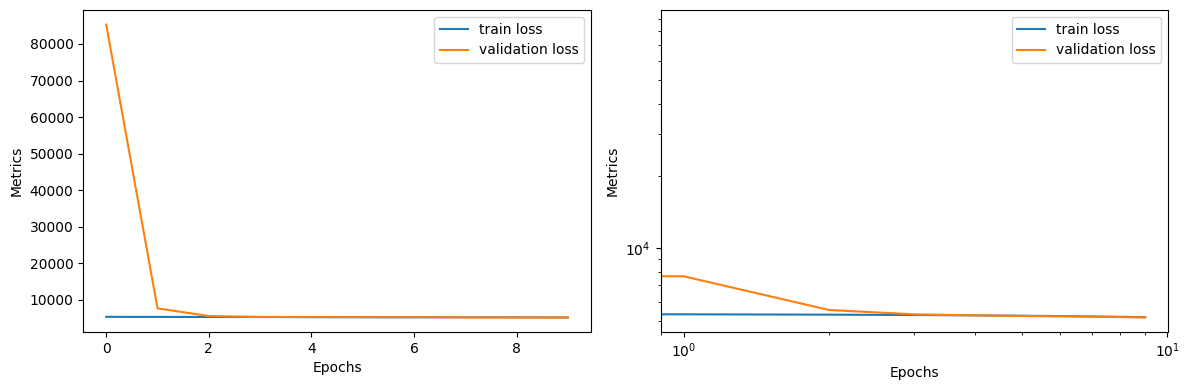

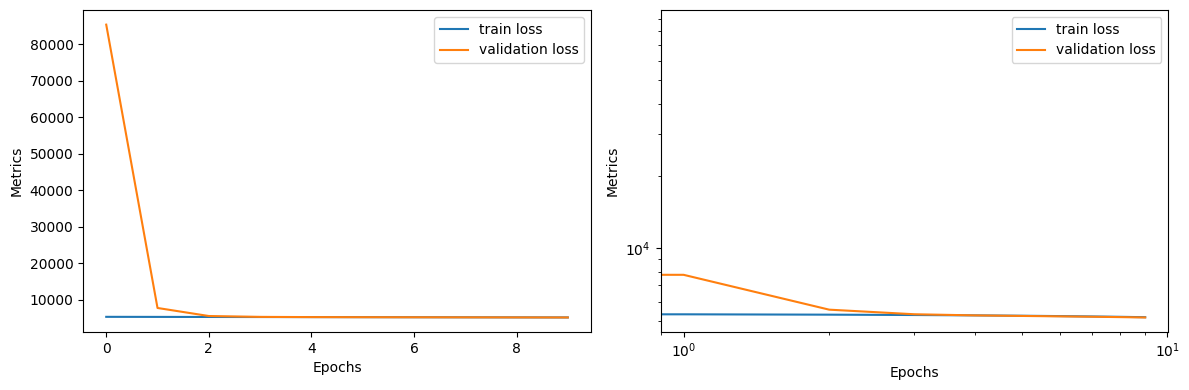

In [25]:
# Plot the loss function over time
plot_history(bnn_fp32_history, metrics=["loss"], plot_log=True)
plot_history(bnn_bf16_history, metrics=["loss"], plot_log=True)

Importing BNN Training Results of Runs with 100 EPOCHS

In [26]:
from collections import deque
import tarfile
import os

dir_name = 'mixed_precision_outputs'

if not os.path.exists(dir_name):
    with tarfile.open(dir_name + ".tar") as tar:
        tar.extractall()

with open(dir_name + '/logs/BNN_Training_Summary_CPU.out', 'r') as file:
    last_lines = deque(file, maxlen=12)
    print(''.join(list(last_lines)[:-2]))

Training took 763.965 seconds
BNN Training Summary on CPU
FP32 training time: 1032.293 seconds with loss: 3397.715576171875
BF16 training time: 763.965 seconds with loss: 3404.361572265625
FP32 total consumed energy: 0.22603 J with emissions: 0.08320 kgCO2
BF16 total consumed energy: 0.16657 J with emissions: 0.06132 kgCO2
FP32 EDP (Energy Delay Product): 233.327 J*s
BF16 EDP (Energy Delay Product): 127.254 J*s
BF16 is 1.35X faster than FP32 with -0.00% accuracy loss
BF16 reduces emissions by 26.31% and EDP by 45.46% than FP32



Next We Test Our Models (loaded from the models run with 100 EPOCHS on Kestrel) for Inference

Negative Log-likelihood Function

In [6]:
# Custom loss function
def negative_log_likelihood(y_true, y_pred):
    return -y_pred.log_prob(y_true)

Run Inference Function where We Load the BNN Models and Perform Ensemble Predictions

In [7]:
import sys
from tfmelt.utils.evaluation import ensemble_predictions

models_dir = 'mixed_precision_outputs/models'
def run_inference(x_train, x_val, x_test, y_normalizer, dataType="fp32"):
    # Set mixed precision policy if needed
    if dataType == "bf16":
        tf.config.optimizer.set_experimental_options({'auto_mixed_precision_onednn_bfloat16':True})
    else:
        tf.keras.mixed_precision.set_global_policy('float32')
    
    model_dir = os.path.join(models_dir, f'bnn_{dataType}_model')
    if not os.path.exists(model_dir):
        sys.exit(f"Model directory {model_dir} does not exist. Ensure that the model has been trained and saved.")

    # Load model with custom objects
    with tf.keras.utils.custom_object_scope({'negative_log_likelihood': negative_log_likelihood}):
        model = tf.keras.models.load_model(model_dir)

    tracker = EmissionsTracker()
    tracker.start()
    start = time.time()
    pred_train_mean, pred_train_std = ensemble_predictions(model, x_train, y_normalizer, unnormalize=True, n_iter=n_epochs, training=True)
    pred_val_mean, pred_val_std = ensemble_predictions(model, x_val, y_normalizer, unnormalize=True, n_iter=n_epochs, training=True)
    pred_test_mean, pred_test_std = ensemble_predictions(model, x_test, y_normalizer, unnormalize=True, n_iter=n_epochs, training=True)
    inference_time = time.time() - start
    emissions: float = tracker.stop()
    total_energy = tracker.final_emissions_data.energy_consumed

    return (pred_train_mean, pred_train_std,
            pred_val_mean, pred_val_std,
            pred_test_mean, pred_test_std,
            inference_time, emissions, total_energy)


In [8]:
# Evaluate FP32 model
print("Evaluating FP32 model")
(fp32_pred_train_mean, fp32_pred_train_std,
     fp32_pred_val_mean, fp32_pred_val_std,
     fp32_pred_test_mean, fp32_pred_test_std,
     fp32_inference_time, fp32_emissions, fp32_total_energy) = run_inference(x_train, x_val, x_test, y_normalizer, dataType="fp32")

# Evaluate BF16 model
print("Evaluating BF16 model")
(bf16_pred_train_mean, bf16_pred_train_std,
     bf16_pred_val_mean, bf16_pred_val_std,
     bf16_pred_test_mean, bf16_pred_test_std,
     bf16_inference_time, bf16_emissions, bf16_total_energy) = run_inference(x_train, x_val, x_test, y_normalizer, dataType="bf16")

Evaluating FP32 model


[codecarbon INFO @ 12:17:25] [setup] RAM Tracking...
[codecarbon INFO @ 12:17:25] [setup] GPU Tracking...
[codecarbon INFO @ 12:17:25] No GPU found.
[codecarbon INFO @ 12:17:25] [setup] CPU Tracking...
[codecarbon INFO @ 12:17:25] Tracking Intel CPU via RAPL interface
[codecarbon INFO @ 12:17:25] >>> Tracker's metadata:
[codecarbon INFO @ 12:17:25]   Platform system: Linux-4.18.0-477.10.1.el8_8.x86_64-x86_64-with-glibc2.28
[codecarbon INFO @ 12:17:25]   Python version: 3.11.9
[codecarbon INFO @ 12:17:25]   CodeCarbon version: 2.5.0
[codecarbon INFO @ 12:17:25]   Available RAM : 246.064 GB
[codecarbon INFO @ 12:17:25]   CPU count: 104
[codecarbon INFO @ 12:17:25]   CPU model: Intel(R) Xeon(R) Platinum 8470
[codecarbon INFO @ 12:17:25]   GPU count: None
[codecarbon INFO @ 12:17:25]   GPU model: None
[codecarbon INFO @ 12:17:28] Saving emissions data to file /home/ttahmid/applications_test/AI/supervised/regression/emissions.csv
[codecarbon INFO @ 12:17:43] Energy consumed for RAM : 0.0003

Evaluating BF16 model


[codecarbon INFO @ 12:18:15] [setup] RAM Tracking...
[codecarbon INFO @ 12:18:15] [setup] GPU Tracking...
[codecarbon INFO @ 12:18:15] No GPU found.
[codecarbon INFO @ 12:18:15] [setup] CPU Tracking...
[codecarbon INFO @ 12:18:15] Tracking Intel CPU via RAPL interface
[codecarbon INFO @ 12:18:15] >>> Tracker's metadata:
[codecarbon INFO @ 12:18:15]   Platform system: Linux-4.18.0-477.10.1.el8_8.x86_64-x86_64-with-glibc2.28
[codecarbon INFO @ 12:18:15]   Python version: 3.11.9
[codecarbon INFO @ 12:18:15]   CodeCarbon version: 2.5.0
[codecarbon INFO @ 12:18:15]   Available RAM : 246.064 GB
[codecarbon INFO @ 12:18:15]   CPU count: 104
[codecarbon INFO @ 12:18:15]   CPU model: Intel(R) Xeon(R) Platinum 8470
[codecarbon INFO @ 12:18:15]   GPU count: None
[codecarbon INFO @ 12:18:15]   GPU model: None
[codecarbon INFO @ 12:18:18] Saving emissions data to file /home/ttahmid/applications_test/AI/supervised/regression/emissions.csv
2024-07-23 12:18:19.224036: I tensorflow/core/grappler/optimi

In [9]:
from tfmelt.utils.visualization import plot_predictions_with_uncertainty

# Inference results
print("Inference Results Summary on CPU")
print(f"FP32 inference time: {fp32_inference_time:.3f} seconds")
print(f"BF16 inference time: {bf16_inference_time:.3f} seconds")
print(f"FP32 total consumed energy: {fp32_total_energy:.5f} J with emissions: {fp32_emissions:.3f} kgCO2")
print(f"BF16 total consumed energy: {bf16_total_energy:.5f} J with emissions: {bf16_emissions:.3f} kgCO2")

# Calculate speedup of BF16 over FP32
bf16_speedup_from_fp32 = fp32_inference_time / bf16_inference_time
print(f"BF16 is {bf16_speedup_from_fp32:.2f}X faster than FP32")

#Calcualte the emissions and EDP reduction percentage
emissions_reduction = ((fp32_emissions - bf16_emissions) / fp32_emissions) * 100
edp_reduction = (((fp32_inference_time * fp32_total_energy) - (bf16_inference_time * bf16_total_energy)) / (fp32_inference_time * fp32_total_energy)) * 100
print(f"BF16 reduces emissions by {emissions_reduction:.2f}% and EDP by {edp_reduction:.2f}% than FP32")

Inference Results Summary on CPU
FP32 inference time: 43.542 seconds
BF16 inference time: 27.094 seconds
FP32 total consumed energy: 0.00892 J with emissions: 0.003 kgCO2
BF16 total consumed energy: 0.00528 J with emissions: 0.002 kgCO2
BF16 is 1.61X faster than FP32
BF16 reduces emissions by 40.86% and EDP by 63.20% than FP32


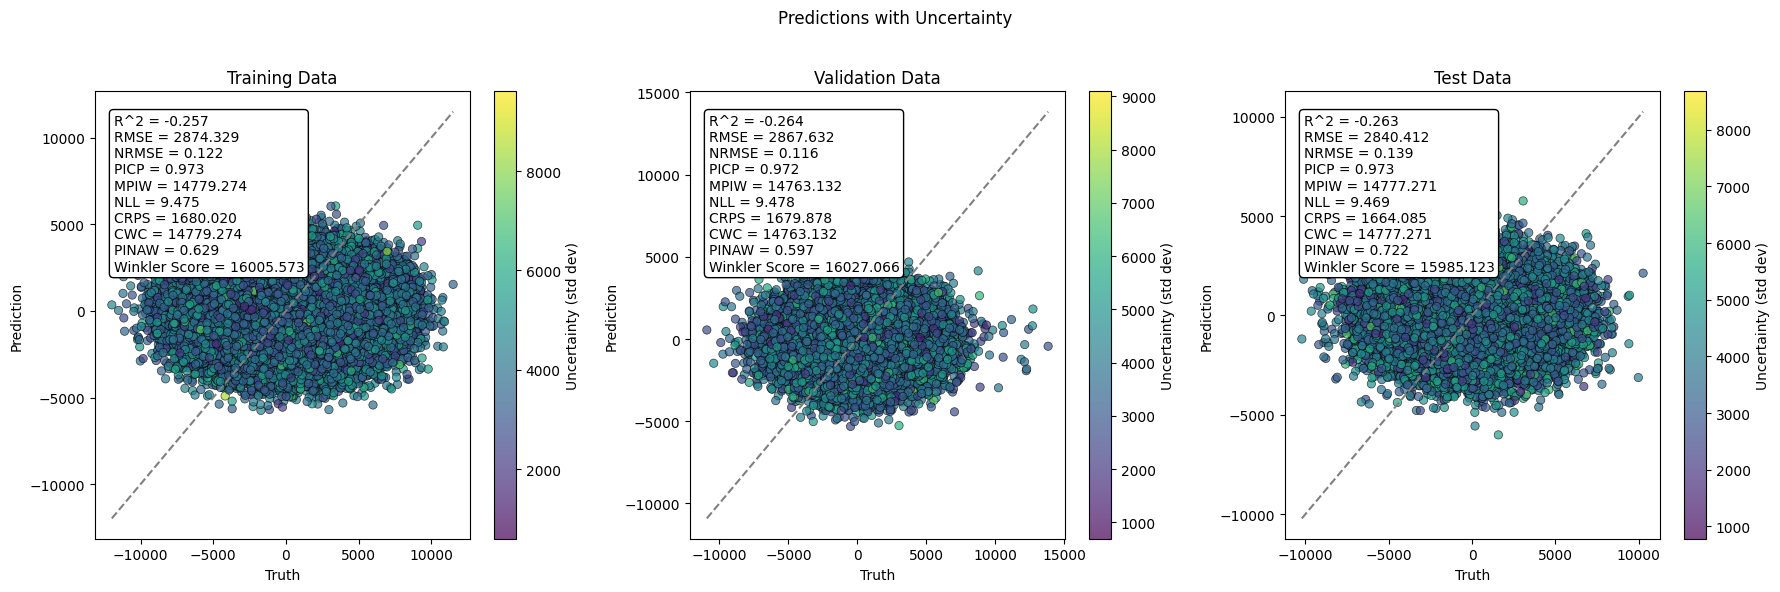

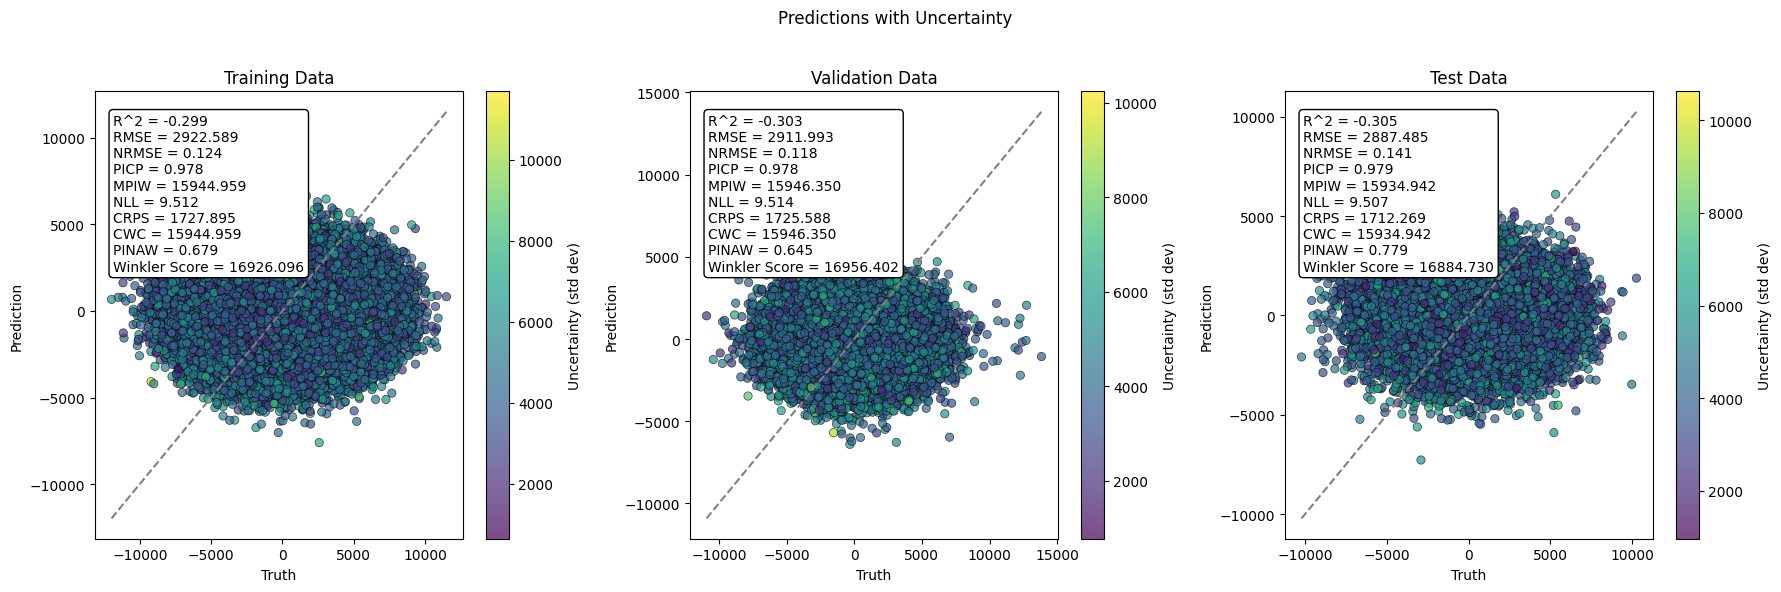

In [10]:
# Plot the predictions from the ensemble
plot_predictions_with_uncertainty(
        fp32_pred_train_mean, fp32_pred_train_std, y_train_real,
        fp32_pred_val_mean, fp32_pred_val_std, y_val_real,
        fp32_pred_test_mean, fp32_pred_test_std, y_test_real,
        metrics_to_display=None)

plot_predictions_with_uncertainty(
        bf16_pred_train_mean, bf16_pred_train_std, y_train_real,
        bf16_pred_val_mean, bf16_pred_val_std, y_val_real,
        bf16_pred_test_mean, bf16_pred_test_std, y_test_real,
        metrics_to_display=None)

Next We Import the Inference Results Performed on a Kestrel Compute Node

In [12]:
from collections import deque
import tarfile
import os

dir_name = 'mixed_precision_outputs'

if not os.path.exists(dir_name):
    with tarfile.open(dir_name + ".tar") as tar:
        tar.extractall()

with open(dir_name + '/logs/tf-melt_all_bnn_inference.out', 'r') as file:
    last_lines = deque(file, maxlen=9)
    print(''.join(list(last_lines)[:-2]))

Inference Results Summary
FP32 inference time: 481.890 seconds
BF16 inference time: 253.182 seconds
FP32 emissions: 0.038 kgCO2
BF16 emissions: 0.020 kgCO2
BF16 is 1.90X faster than FP32
BF16 reduces emissions by 47.53%

